# Training and analysis script for ViT Classifier of PIScO Plankton images
Version: 250611


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"#"0,1"

import torch
import numpy as np
from datasets import load_dataset, DatasetDict, ClassLabel#, load_metric
from datasets import Dataset, Features, Image as ImageFeature, Value, concatenate_datasets
from PIL import Image
import torchvision.transforms as transforms
from transformers import AutoImageProcessor
import torchvision.transforms.functional as F
from transformers import Trainer
import evaluate
from transformers import TrainingArguments

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict

import matplotlib.pyplot as plt
import random
from transformers import AutoImageProcessor, ViTForImageClassification

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

from torch.utils.data import DataLoader
from tqdm import tqdm

import pandas as pd
import logging


/home/veit/miniconda3/envs/pisco/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Core Functions

In [2]:
def merge_datasets(dataset_paths, output_dir="merged_dataset"):
    """
    Merge multiple image datasets while handling scale bars into a permanent directory.
    
    Args:
        dataset_paths (dict): Dictionary with dataset paths as keys and scale bar flags as values
            Example: {'/path/to/dataset1': True, '/path/to/dataset2': False}
        output_dir (str): Path where the merged dataset will be stored
    
    Returns:
        datasets.Dataset: Merged dataset
    """
    import os
    from PIL import Image
    from datasets import load_dataset
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each dataset
    for dataset_path, has_scale_bar in dataset_paths.items():
        print(f"Processing dataset: {dataset_path}")
        # Iterate through all class directories in the source dataset
        for class_name in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_name)
            
            # Skip if not a directory
            if not os.path.isdir(class_path):
                continue
            
            # Create corresponding class directory in output folder
            output_class_path = os.path.join(output_dir, class_name)
            os.makedirs(output_class_path, exist_ok=True)
            # print(f"Processing class: {class_name}")
            
            # Process each image in the class directory
            for img_name in os.listdir(class_path):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
                    continue
                    
                img_path = os.path.join(class_path, img_name)
                output_path = os.path.join(output_class_path, img_name)
                
                # Skip if image already exists in output directory
                if os.path.exists(output_path):
                    continue
                
                try:
                    # Open and process image
                    with Image.open(img_path) as img:
                        # Convert to RGB if necessary
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        
                        # Remove scale bar if needed
                        if has_scale_bar:
                            width, height = img.size
                            img = img.crop((0, 0, width, height - 50))
                        
                        # Save processed image to output directory
                        img.save(output_path)
                        
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
                    continue
    
    print(f"\nMerged dataset saved to: {output_dir}")
    # Load the merged dataset using datasets library
    merged_dataset = load_dataset("imagefolder", data_dir=output_dir)
    
    return merged_dataset['train']

In [3]:
def visualize_transformations(dataset, original_ds, num_samples=25, rows=5, cols=5):
    # Randomly sample indices
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    for idx, sample_idx in enumerate(random_indices):
        # Get original image and transformed version
        original = original_ds[sample_idx]
        transformed = dataset[sample_idx]
        
        label = original_ds.features['label'].names[original['label']]
        
        # Original image
        plt.subplot(rows, cols*2, idx*2 + 1)
        plt.imshow(original['image'])
        plt.title(f'Original\n{label}', fontsize=8)
        plt.axis('off')
        
        # Transformed image
        plt.subplot(rows, cols*2, idx*2 + 2)
        # Convert tensor to numpy and adjust for display
        transformed_img = transformed['pixel_values'].permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(transformed_img)
        plt.title('Transformed', fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_label_distribution(dataset, title="Label Distribution"):
    # Count labels
    label_counts = Counter(dataset['label'])
    
    # Convert to percentages
    total_samples = len(dataset)
    label_percentages = {dataset.features['label'].names[k]: (v/total_samples)*100 
                        for k, v in label_counts.items()}
    
    # Sort by frequency
    sorted_items = sorted(label_percentages.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)
    
    # Create figure with sufficient height for labels
    plt.figure(figsize=(15, 8))
    
    # Create bar plot
    bars = plt.bar(labels, values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage of Dataset (%)')
    plt.title(title)
    
    # Add percentage values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    # Print statistics
    print(f"\nDataset Statistics:")
    print(f"Total samples: {total_samples}")
    print(f"\nClass distribution:")
    for label, percentage in sorted_items:
        count = int(percentage * total_samples / 100)
        print(f"{label}: {count} samples ({percentage:.1f}%)")
    
    # Calculate imbalance ratio (majority:minority)
    max_samples = max(label_counts.values())
    min_samples = min(label_counts.values())
    imbalance_ratio = max_samples / min_samples
    print(f"\nImbalance ratio (majority:minority): {imbalance_ratio:.1f}:1")
    
    plt.tight_layout()
    plt.show()

def preprocess_dataset(dataset, min_samples=10, max_samples=1000, merge_classes=None, exclude_classes=None):
    """
    Preprocess dataset with class merging, exclusion, and sample count constraints.
    """
    # Group samples by label
    label_groups = defaultdict(list)
    labels = dataset.features['label'].names
    
    for idx, item in enumerate(dataset):
        current_label = labels[item['label']]
        label_groups[current_label].append(idx)
    
    # Create mapping for merged classes
    merged_to_new = {}
    if merge_classes:
        for new_class, classes_to_merge in merge_classes.items():
            for old_class in classes_to_merge:
                merged_to_new[old_class] = new_class
    
    # Remove excluded classes
    if exclude_classes:
        for class_name in exclude_classes:
            if class_name in label_groups:
                print(f"Excluding class: {class_name}")
                del label_groups[class_name]
    
    # Merge classes if specified
    if merge_classes:
        for new_class, classes_to_merge in merge_classes.items():
            # Skip if new class is in excluded classes
            if exclude_classes and new_class in exclude_classes:
                continue
            # Collect all indices for classes to merge
            merged_indices = []
            for class_name in classes_to_merge:
                if class_name in label_groups:
                    merged_indices.extend(label_groups[class_name])
                    del label_groups[class_name]
            # Add merged class if it has enough samples
            if len(merged_indices) >= min_samples:
                label_groups[new_class] = merged_indices
    
    # Filter and sample classes
    valid_indices = []
    new_label_mapping = {}
    new_label_names = []
    current_label_id = 0
    
    for class_name, indices in label_groups.items():
        if len(indices) < min_samples:
            print(f"Dropping class {class_name}: only {len(indices)} samples (min: {min_samples})")
            continue
        
        if len(indices) > max_samples:
            print(f"Sampling {max_samples} from {len(indices)} samples for class {class_name}")
            indices = random.sample(indices, max_samples)
        
        valid_indices.extend(indices)
        new_label_mapping[class_name] = current_label_id
        new_label_names.append(class_name)
        current_label_id += 1
    
    def remap_labels(example):
        old_label = labels[example['label']]
        # Check if this label should be merged
        if old_label in merged_to_new:
            old_label = merged_to_new[old_label]
        new_label = new_label_mapping[old_label]
        return {'image': example['image'], 'label': new_label}
    
    # Select valid indices and remap labels
    filtered_dataset = dataset.select(valid_indices).map(remap_labels)
    
    # Update label names in dataset features
    filtered_dataset = filtered_dataset.cast_column("label", 
        ClassLabel(names=new_label_names))
    
    return filtered_dataset

In [4]:
def resize_to_larger_edge(image, target_size):
    # Get the original dimensions of the image
    original_width, original_height = image.size
    
    # Determine which dimension is larger
    larger_edge = max(original_width, original_height)
    
    # Compute the scale factor to resize the larger edge to the target size
    scale_factor = target_size / larger_edge
    
    # Compute new dimensions
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)
    
    try:
    # Resize the image
        resized_image = F.resize(image, (new_height, new_width))
    except(ValueError):
        #print(image.size,new_height,new_width)
        logging.info(f"Skipping: {image}: image size: {image.size}, new height: {new_height}, new width: {new_width}")
        return None        
    return resized_image

def custom_image_processor(image, target_size=(224, 224), padding_color=255, size_bar=False):
    if image.mode != 'RGB':
        image = image.convert('RGB')

    if size_bar:
        # Step 0: Remove scale bar by cropping the bottom 50 pixels
        width, height = image.size
        image = image.crop((0, 0, width, height - 50))  # Crop out the scale bar area
    
    # Step 1: Resize the image
    resized_image = resize_to_larger_edge(image,224)

    if resized_image is None:  # Skip processing if resizing failed
        #print(f"Skipping image due to resize failure: {image.size}")
        return None  # This allows to filter out bad images later

    #Step 2: Calculate padding
    new_width, new_height = resized_image.size
    padding_left = (target_size[0] - new_width) // 2
    padding_right = target_size[0] - new_width - padding_left
    padding_top = (target_size[1] - new_height) // 2
    padding_bottom = target_size[1] - new_height - padding_top

    # Step 3: Apply padding
    padding = (padding_left, padding_top, padding_right, padding_bottom)
    pad_transform = transforms.Pad(padding, fill=padding_color)
    padded_image = pad_transform(resized_image)

    # Step 4: Apply other transformations
    transform_chain = transforms.Compose([
        transforms.RandomRotation(degrees=180,fill=255),
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    ])
    
    # Apply the transformations
    return transform_chain(padded_image)

# Example function to process a batch
def process_batch(example_batch):
    # Process each image in the batch
    processed_images = [
        custom_image_processor(img) 
        for img in example_batch['image']
        if custom_image_processor(img) is not None
        ]
    
    # Convert to a batch tensor
    inputs = torch.stack(processed_images)
    
    # Include labels (assuming they are present and you want to keep them)
    return {'pixel_values': inputs, 'label': example_batch['label']}


### Loading and analysis of the  datasets from Ecotaxa export of validated/annotated images (General export with folders for categories).
Configuring for balanced training. Here we can still tune a lot.

### Binary dataset

Processing dataset: /home/veit/Downloads/export__TSV_17420_20250627_0905
Processing dataset: /home/veit/Downloads/export__TSV_17108_20250630_1327

Merged dataset saved to: /home/veit/Documents/M181_binary_deconv_trainset
Original labels: ['Acantharia', 'Appendicularia', 'Arthracanthida', 'Asteroidea larvae', 'Aulacanthidae', 'Aulosphaeridae', 'Bacillariophyceae', 'Calanoida', 'Cannosphaeridae', 'Chaetognatha', 'Chordata', 'Cnidaria_Metazoa', 'Coelodendridae', 'Copepoda_Maxillopoda', 'Crustacea', 'Ctenophora_Metazoa', 'Decapoda', 'Doliolida', 'Echinodermata', 'Eumalacostraca', 'Foraminifera', 'Malacostraca', 'Medusettidae', 'Mollusca', 'Noctiluca sp.', 'Oithona', 'Ophiuroidea', 'Polychaeta', 'Pyrocystis', 'Rhizaria', 'Salpida', 'Siphonophorae', 'Solmundella', 'Thaliacea', 'Trichodesmium', 'Tuscaroridae', 'aggregate-fluffy-grey-to-compact', 'aggregates', 'artefact', 'body_Appendicularia', 'bubble', 'chain_Salpida', 'dark_fluffy', 'dark_sphere', 'detritus', 'fecal pellets', 'fiber_detritu

Casting the dataset: 100%|██████████| 20000/20000 [00:00<00:00, 249966.72 examples/s]



Final dataset distribution:

Train Set Distribution:

Dataset Statistics:
Total samples: 12000

Class distribution:
living: 6000 samples (50.0%)
non_living: 6000 samples (50.0%)

Imbalance ratio (majority:minority): 1.0:1


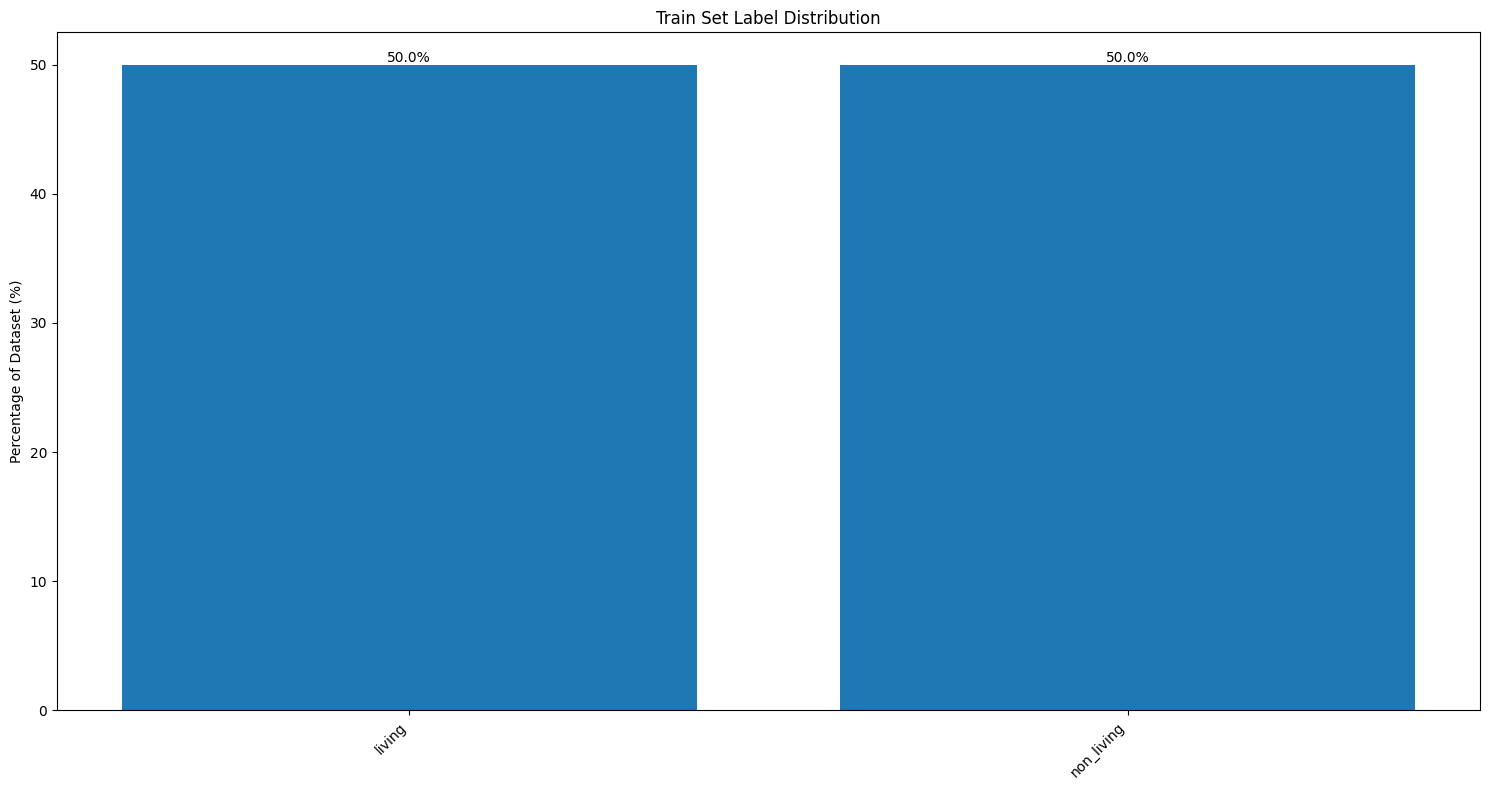


Validation Set Distribution:

Dataset Statistics:
Total samples: 4000

Class distribution:
non_living: 2000 samples (50.0%)
living: 2000 samples (50.0%)

Imbalance ratio (majority:minority): 1.0:1


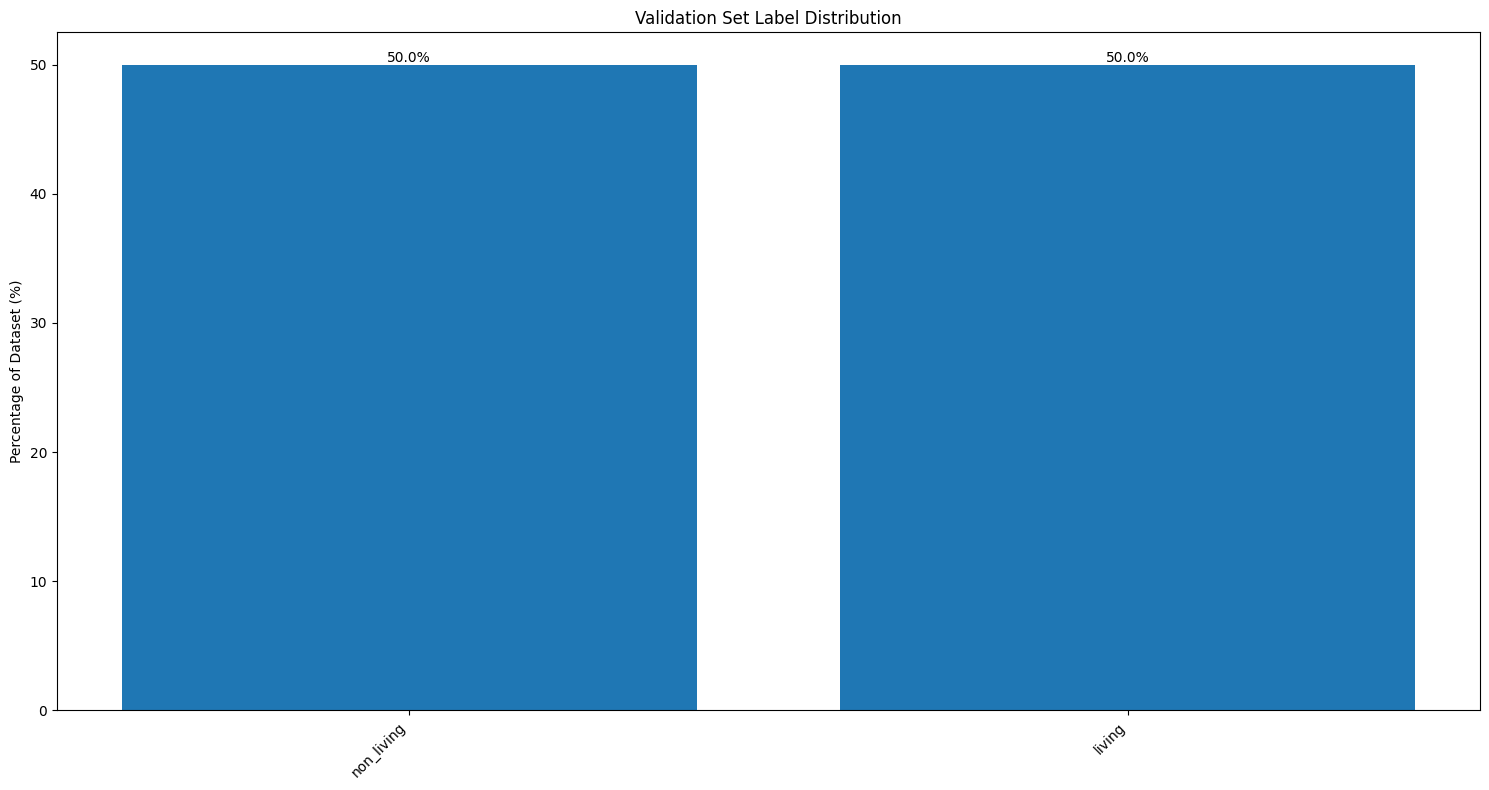


Test Set Distribution:

Dataset Statistics:
Total samples: 4000

Class distribution:
living: 2000 samples (50.0%)
non_living: 2000 samples (50.0%)

Imbalance ratio (majority:minority): 1.0:1


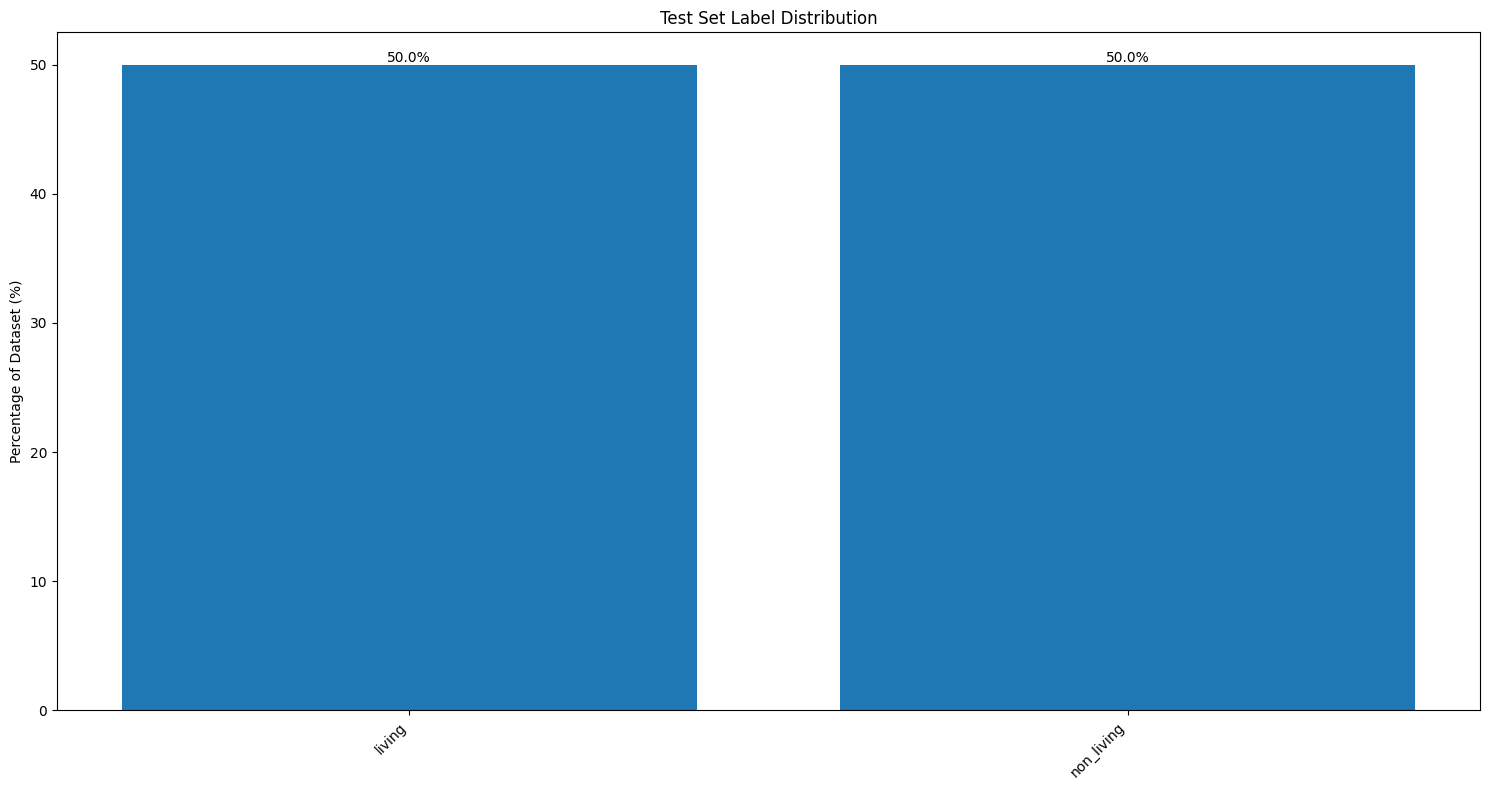

In [8]:
# First set up the 2 class dataset
# we need to merge all classes into 2 classes
# First define your dataset paths and scale bar flags
dataset_paths = {
    '/home/veit/Downloads/export__TSV_17420_20250627_0905': False,
    '/home/veit/Downloads/export__TSV_17108_20250630_1327': True,
}

# Specify the output directory for the merged dataset
output_dir = "/home/veit/Documents/M181_binary_deconv_trainset"

# Merge the datasets
merged_ds = merge_datasets(dataset_paths, output_dir=output_dir)

labels = merged_ds.features['label'].names
print(f"Original labels: {labels}")

# Classes to merge

living_classes = set(['Acantharia', 'Appendicularia', 'Arthracanthida', 'Asteroidea larvae', 'Aulacanthidae', 'Aulosphaeridae', 'Bacillariophyceae', 'Calanoida', 'Cannosphaeridae', 'Chaetognatha', 'Cnidaria_Metazoa', 'Coelodendridae', 'Copepoda_Maxillopoda', 'Crustacea', 'Ctenophora_Metazoa', 'Decapoda', 'Doliolida', 'Echinodermata', 'Eumalacostraca', 'Foraminifera', 'Malacostraca', 'Medusettidae', 'Mollusca', 'multiple_other', 'Noctiluca sp.', 'Oithona', 'Ophiuroidea', 'Polychaeta', 'Pyrocystis', 'Rhizaria', 'Salpida', 'Siphonophorae', 'Solmundella', 'Thaliacea', 'Trichodesmium', 'Tuscaroridae', 'body_Appendicularia', 'chain_Salpida',  'gelatinous', 'house',  'nurse', 'other_living', 'othertocheck', 'part_Cnidaria', 'part_other', 'pluteus_Ophiuroidea', 'puff',  'sphere_Phaeodaria', 'sphere_othertocheck',  'tentacle_Cnidaria', 'tuft'])
merge_classes = {
    'living': list(living_classes)
    ,
    'non_living': list(set(labels) - living_classes)
}
print(f"Classes to merge: {merge_classes}")

exclude_classes = None

# Process the full dataset before splitting
processed_full_ds = preprocess_dataset(
    merged_ds,
    min_samples=5,      # Minimum 5 samples per class
    max_samples=10000,    # Maximum 500 samples per class
    merge_classes=merge_classes,
    exclude_classes=exclude_classes
)

# Then split into train/validation/test
train_val_test = processed_full_ds.train_test_split(
    test_size=0.2,
    seed=42,
    shuffle=True,
    stratify_by_column="label"
)

train_val = train_val_test['train'].train_test_split(
    test_size=0.25,
    seed=42,
    shuffle=True,
    stratify_by_column="label"
)

ds = DatasetDict({
    'train': train_val['train'],
    'validation': train_val['test'],
    'test': train_val_test['test']
})

# Verify the distribution
print("\nFinal dataset distribution:")
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} Set Distribution:")
    analyze_label_distribution(ds[split], f"{split.capitalize()} Set Label Distribution")

labels = ds['train'].features['label'].names

# Apply the custom image processor to the dataset
prepared_ds = ds.with_transform(process_batch)


### Multiclass dataset

Processing dataset: /home/veit/Downloads/export__TSV_17420_20250627_0905
Processing dataset: /home/veit/Downloads/export__TSV_17108_20250630_1327

Merged dataset saved to: /home/veit/Documents/M181_reinforced_deconv_trainset


Classes to merge: {'Appendicularia': ['Appendicularia', 'body_Appendicularia'], 'Thaliacea': ['chain_Salpida', 'Thaliacea', 'nurse', 'Salpida', 'Doliolida'], 'Cnidaria': ['Cnidaria_Metazoa', 'part_Cnidaria', 'tentacle_Cnidaria', 'gelatinous', 'Siphonophorae', 'Solmundella'], 'Eumalacostraca': ['Malacostraca', 'Eumalacostraca', 'Crustacea', 'Decapoda'], 'Rhizaria': ['Acantharia', 'Aulacanthidae', 'Aulosphaeridae', 'Foraminifera', 'Phaeodaria', 'sphere_Phaeodaria', 'Medusettidae', 'Coelodendridae', 'Cannosphaeridae', 'Tuscaroridae']}
Excluding class: sphere_detritus
Excluding class: t001
Excluding class: bubble
Excluding class: like_Copepoda
Excluding class: detritus
Excluding class: dark_fluffy
Excluding class: aggregates
Excluding class: noise
Excluding class: fecal pellets
Excluding class: solitaryblack
Excluding class: fiber_detritus
Excluding class: dark_sphere
Excluding class: streak
Excluding class: like_Acantharea
Excluding class: light form
Excluding class: like_body
Excluding c

Casting the dataset: 100%|██████████| 8886/8886 [00:00<00:00, 120132.36 examples/s]



Final dataset distribution:

Train Set Distribution:

Dataset Statistics:
Total samples: 5331

Class distribution:
Rhizaria: 600 samples (11.3%)
Appendicularia: 600 samples (11.3%)
Copepoda_Maxillopoda: 597 samples (11.2%)
Thaliacea: 492 samples (9.2%)
Cnidaria: 471 samples (8.8%)
Calanoida: 427 samples (8.0%)
Noctiluca sp.: 363 samples (6.8%)
Chaetognatha: 337 samples (6.3%)
Bacillariophyceae: 330 samples (6.2%)
tuft: 292 samples (5.5%)
puff: 249 samples (4.7%)
Eumalacostraca: 235 samples (4.4%)
Oithona: 135 samples (2.5%)
Asteroidea larvae: 117 samples (2.2%)
Ctenophora_Metazoa: 55 samples (1.0%)
Pyrocystis: 30 samples (0.6%)

Imbalance ratio (majority:minority): 20.0:1


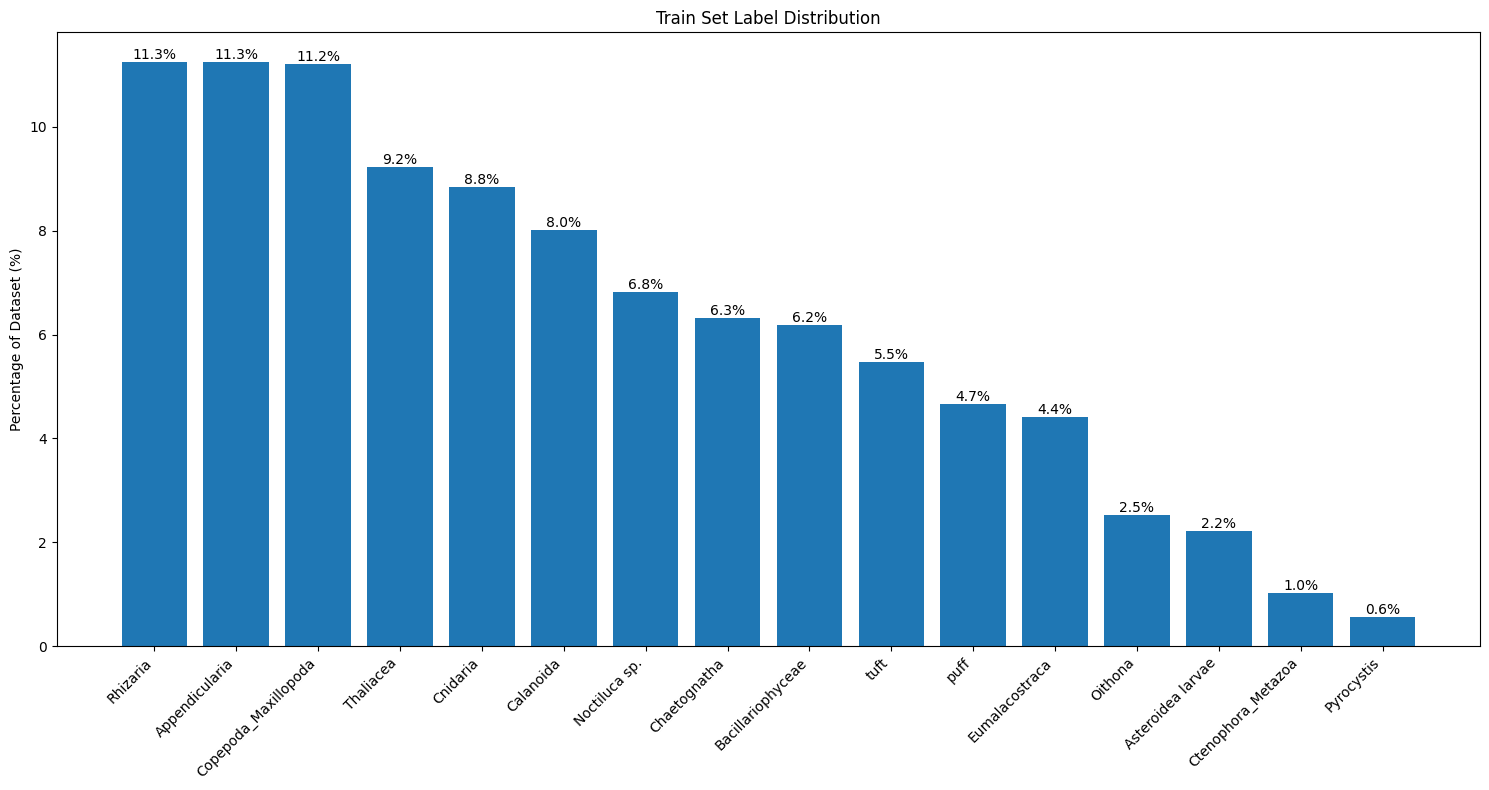


Validation Set Distribution:

Dataset Statistics:
Total samples: 1777

Class distribution:
Appendicularia: 200 samples (11.3%)
Rhizaria: 200 samples (11.3%)
Copepoda_Maxillopoda: 199 samples (11.2%)
Thaliacea: 164 samples (9.2%)
Cnidaria: 157 samples (8.8%)
Calanoida: 142 samples (8.0%)
Noctiluca sp.: 121 samples (6.8%)
Chaetognatha: 111 samples (6.3%)
Bacillariophyceae: 111 samples (6.2%)
tuft: 97 samples (5.5%)
puff: 83 samples (4.7%)
Eumalacostraca: 78 samples (4.4%)
Oithona: 46 samples (2.6%)
Asteroidea larvae: 39 samples (2.2%)
Ctenophora_Metazoa: 18 samples (1.0%)
Pyrocystis: 10 samples (0.6%)

Imbalance ratio (majority:minority): 20.0:1


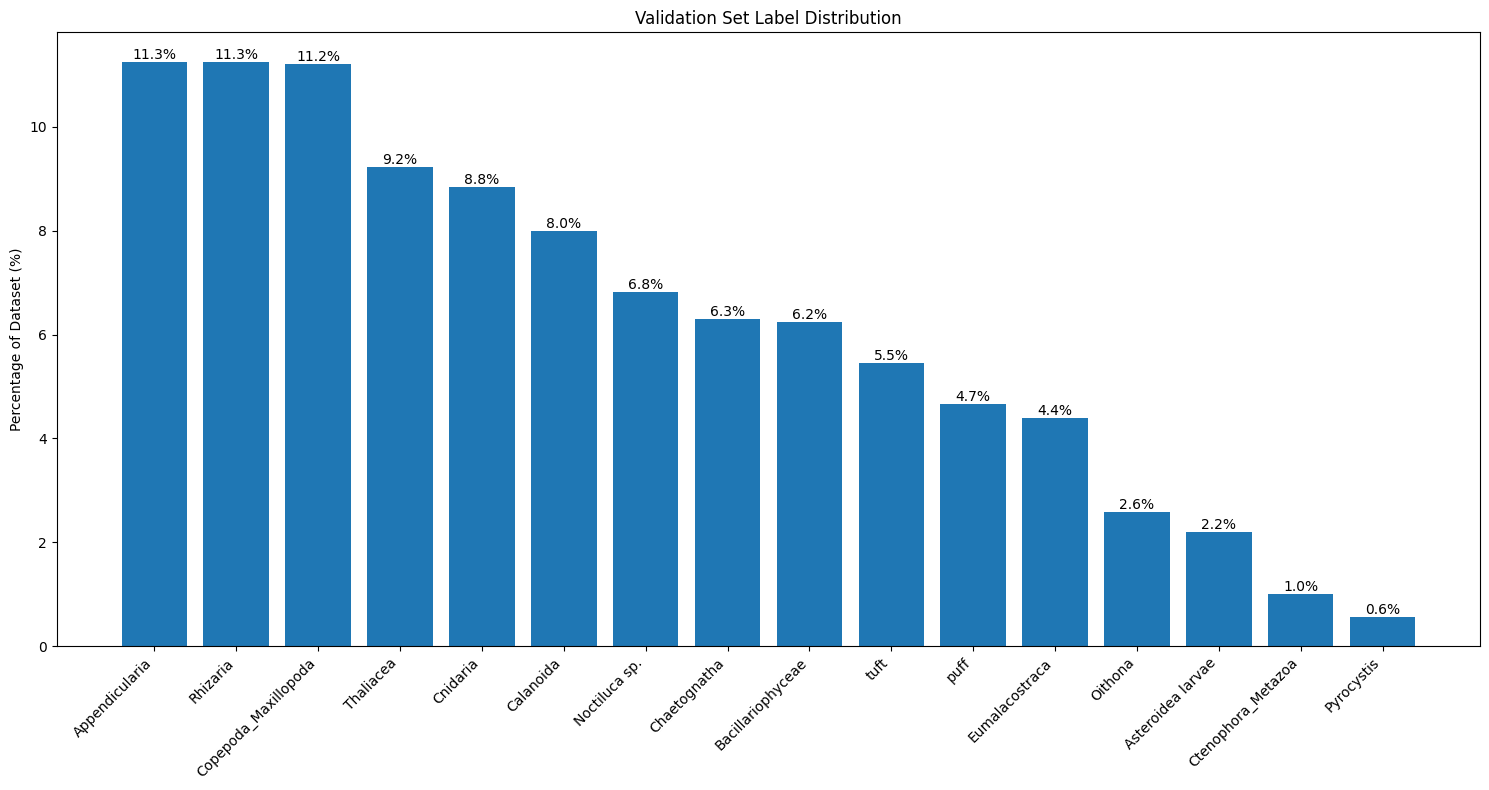


Test Set Distribution:

Dataset Statistics:
Total samples: 1778

Class distribution:
Appendicularia: 200 samples (11.2%)
Rhizaria: 200 samples (11.2%)
Copepoda_Maxillopoda: 199 samples (11.2%)
Thaliacea: 163 samples (9.2%)
Cnidaria: 157 samples (8.8%)
Calanoida: 142 samples (8.0%)
Noctiluca sp.: 121 samples (6.8%)
Chaetognatha: 111 samples (6.3%)
Bacillariophyceae: 110 samples (6.2%)
tuft: 97 samples (5.5%)
puff: 83 samples (4.7%)
Eumalacostraca: 78 samples (4.4%)
Oithona: 46 samples (2.6%)
Asteroidea larvae: 40 samples (2.2%)
Ctenophora_Metazoa: 19 samples (1.1%)
Pyrocystis: 10 samples (0.6%)

Imbalance ratio (majority:minority): 20.0:1


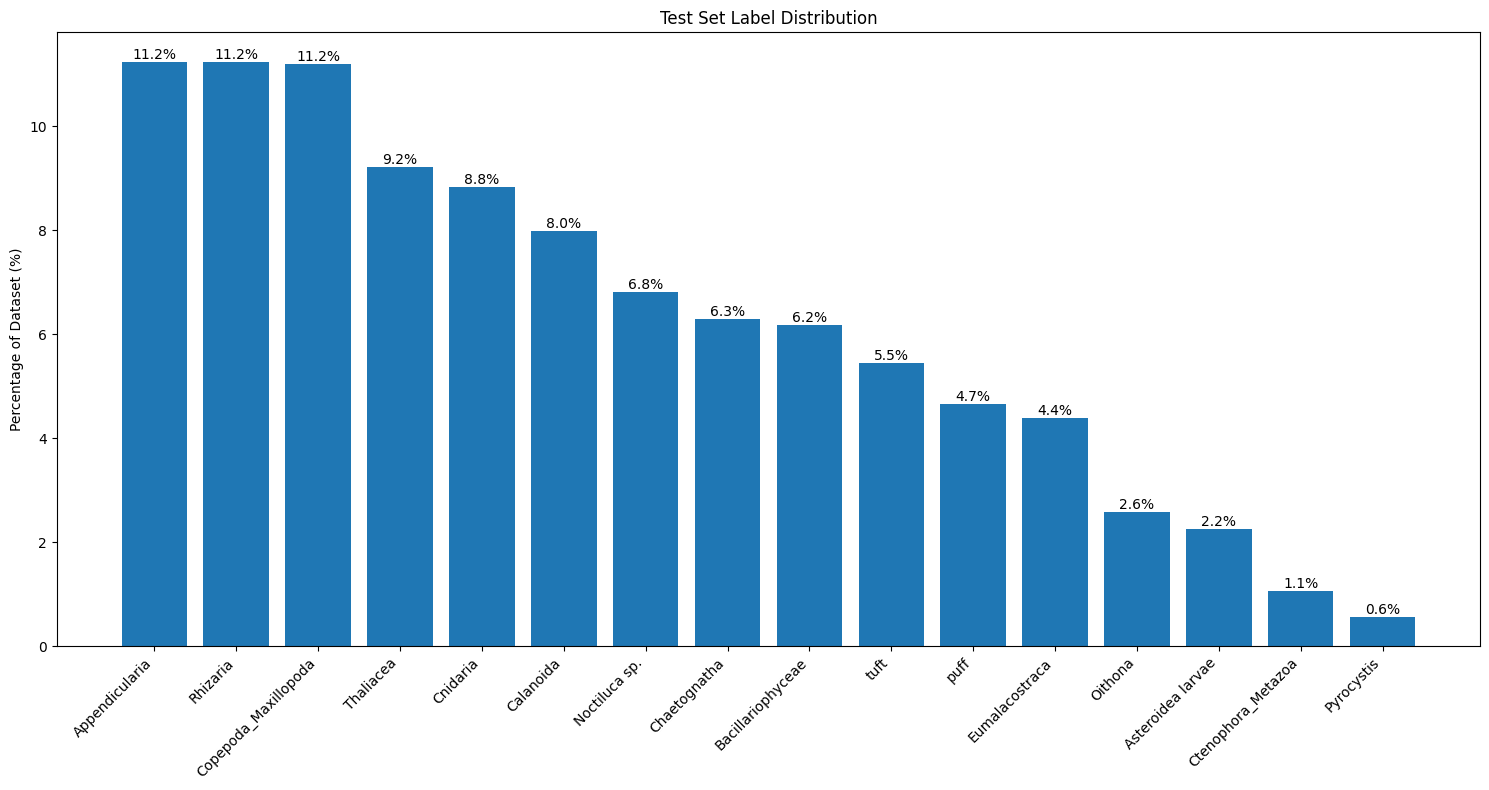


Final labels: ['Asteroidea larvae', 'Bacillariophyceae', 'Calanoida', 'Chaetognatha', 'Copepoda_Maxillopoda', 'Ctenophora_Metazoa', 'Noctiluca sp.', 'Oithona', 'Pyrocystis', 'Rhizaria', 'puff', 'tuft', 'Appendicularia', 'Thaliacea', 'Cnidaria', 'Eumalacostraca']


In [ ]:
#root_dir = '/home/veit/Documents/M181_raw_trainset'
#root_dir = '/home/veit/Downloads/export__TSV_17108_20250616_1412'

# First define your dataset paths and scale bar flags
dataset_paths = {
    '/home/veit/Downloads/export__TSV_17420_20250627_0905': False,
    '/home/veit/Downloads/export__TSV_17108_20250630_1327': True,
}

# Specify the output directory for the merged dataset
output_dir = "/home/veit/Documents/M181_reinforced_deconv_trainset"

# Merge the datasets
merged_ds = merge_datasets(dataset_paths, output_dir=output_dir)

labels = merged_ds.features['label'].names

# First load the full dataset
#full_ds = load_dataset("imagefolder", data_dir=root_dir)

# Classes to merge
merge_classes = {
    'Appendicularia': ['Appendicularia', 'body_Appendicularia'],
    #'detritus': ['detritus_small', 'detritus_large', 'marine_snow']
}

# Classes to merge

living_classes = set(['Acantharia', 'Appendicularia', 'Arthracanthida', 'Asteroidea larvae', 'Aulacanthidae', 'Aulosphaeridae', 'Bacillariophyceae', 'Calanoida', 'Cannosphaeridae', 'Chaetognatha', 'Cnidaria_Metazoa', 'Coelodendridae', 'Copepoda_Maxillopoda', 'Crustacea', 'Ctenophora_Metazoa', 'Decapoda', 'Doliolida', 'Echinodermata', 'Eumalacostraca', 'Foraminifera', 'Malacostraca', 'Medusettidae', 'Mollusca', 'multiple_other', 'Noctiluca sp.', 'Oithona', 'Ophiuroidea', 'Polychaeta', 'Pyrocystis', 'Rhizaria', 'Salpida', 'Siphonophorae', 'Solmundella', 'Thaliacea', 'Trichodesmium', 'Tuscaroridae', 'body_Appendicularia', 'chain_Salpida',  'gelatinous', 'house',  'nurse', 'other_living', 'othertocheck', 'part_Cnidaria', 'part_other', 'pluteus_Ophiuroidea', 'puff',  'sphere_Phaeodaria', 'sphere_othertocheck',  'tentacle_Cnidaria', 'tuft'])
merge_classes = {
    'Appendicularia': ['Appendicularia', 'body_Appendicularia'],
    'Thaliacea': ['chain_Salpida', 'Thaliacea', 'nurse', 'Salpida', 'Doliolida'],
    'Cnidaria<Metazoa': ['Cnidaria_Metazoa', 'part_Cnidaria', 'tentacle_Cnidaria', 'gelatinous', 'Siphonophorae', 'Solmundella'],
    'Eumalacostraca': ['Malacostraca', 'Eumalacostraca', 'Crustacea', 'Decapoda'],
    'Rhizaria': ['Acantharia', 'Aulacanthidae', 'Aulosphaeridae', 'Foraminifera', 'Phaeodaria', 'sphere_Phaeodaria', 'Medusettidae', 'Coelodendridae', 'Cannosphaeridae', 'Tuscaroridae'],       
}
print(f"Classes to merge: {merge_classes}")

# Classes to exclude
#exclude_classes = ['othertocheck', 'sphere_othertocheck', 'multiple_other']  
exclude_classes = list(set(labels) - living_classes)+ ['othertocheck', 'sphere_othertocheck', 'multiple_other']

# Process the full dataset before splitting
processed_full_ds = preprocess_dataset(
    merged_ds,
    min_samples=50,      # Minimum 5 samples per class
    max_samples=1000,    # Maximum 500 samples per class
    merge_classes=merge_classes,
    exclude_classes=exclude_classes
)

# Then split into train/validation/test
train_val_test = processed_full_ds.train_test_split(
    test_size=0.2,
    seed=42,
    shuffle=True,
    stratify_by_column="label"
)

train_val = train_val_test['train'].train_test_split(
    test_size=0.25,
    seed=42,
    shuffle=True,
    stratify_by_column="label"
)

ds = DatasetDict({
    'train': train_val['train'],
    'validation': train_val['test'],
    'test': train_val_test['test']
})

# Verify the distribution
print("\nFinal dataset distribution:")
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} Set Distribution:")
    analyze_label_distribution(ds[split], f"{split.capitalize()} Set Label Distribution")

labels = ds['train'].features['label'].names
print(f"\nFinal labels: {labels}")

# Apply the custom image processor to the dataset
prepared_ds = ds.with_transform(process_batch)

In [28]:
# Dataset structure and sample counts

ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5331
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1777
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1778
    })
})

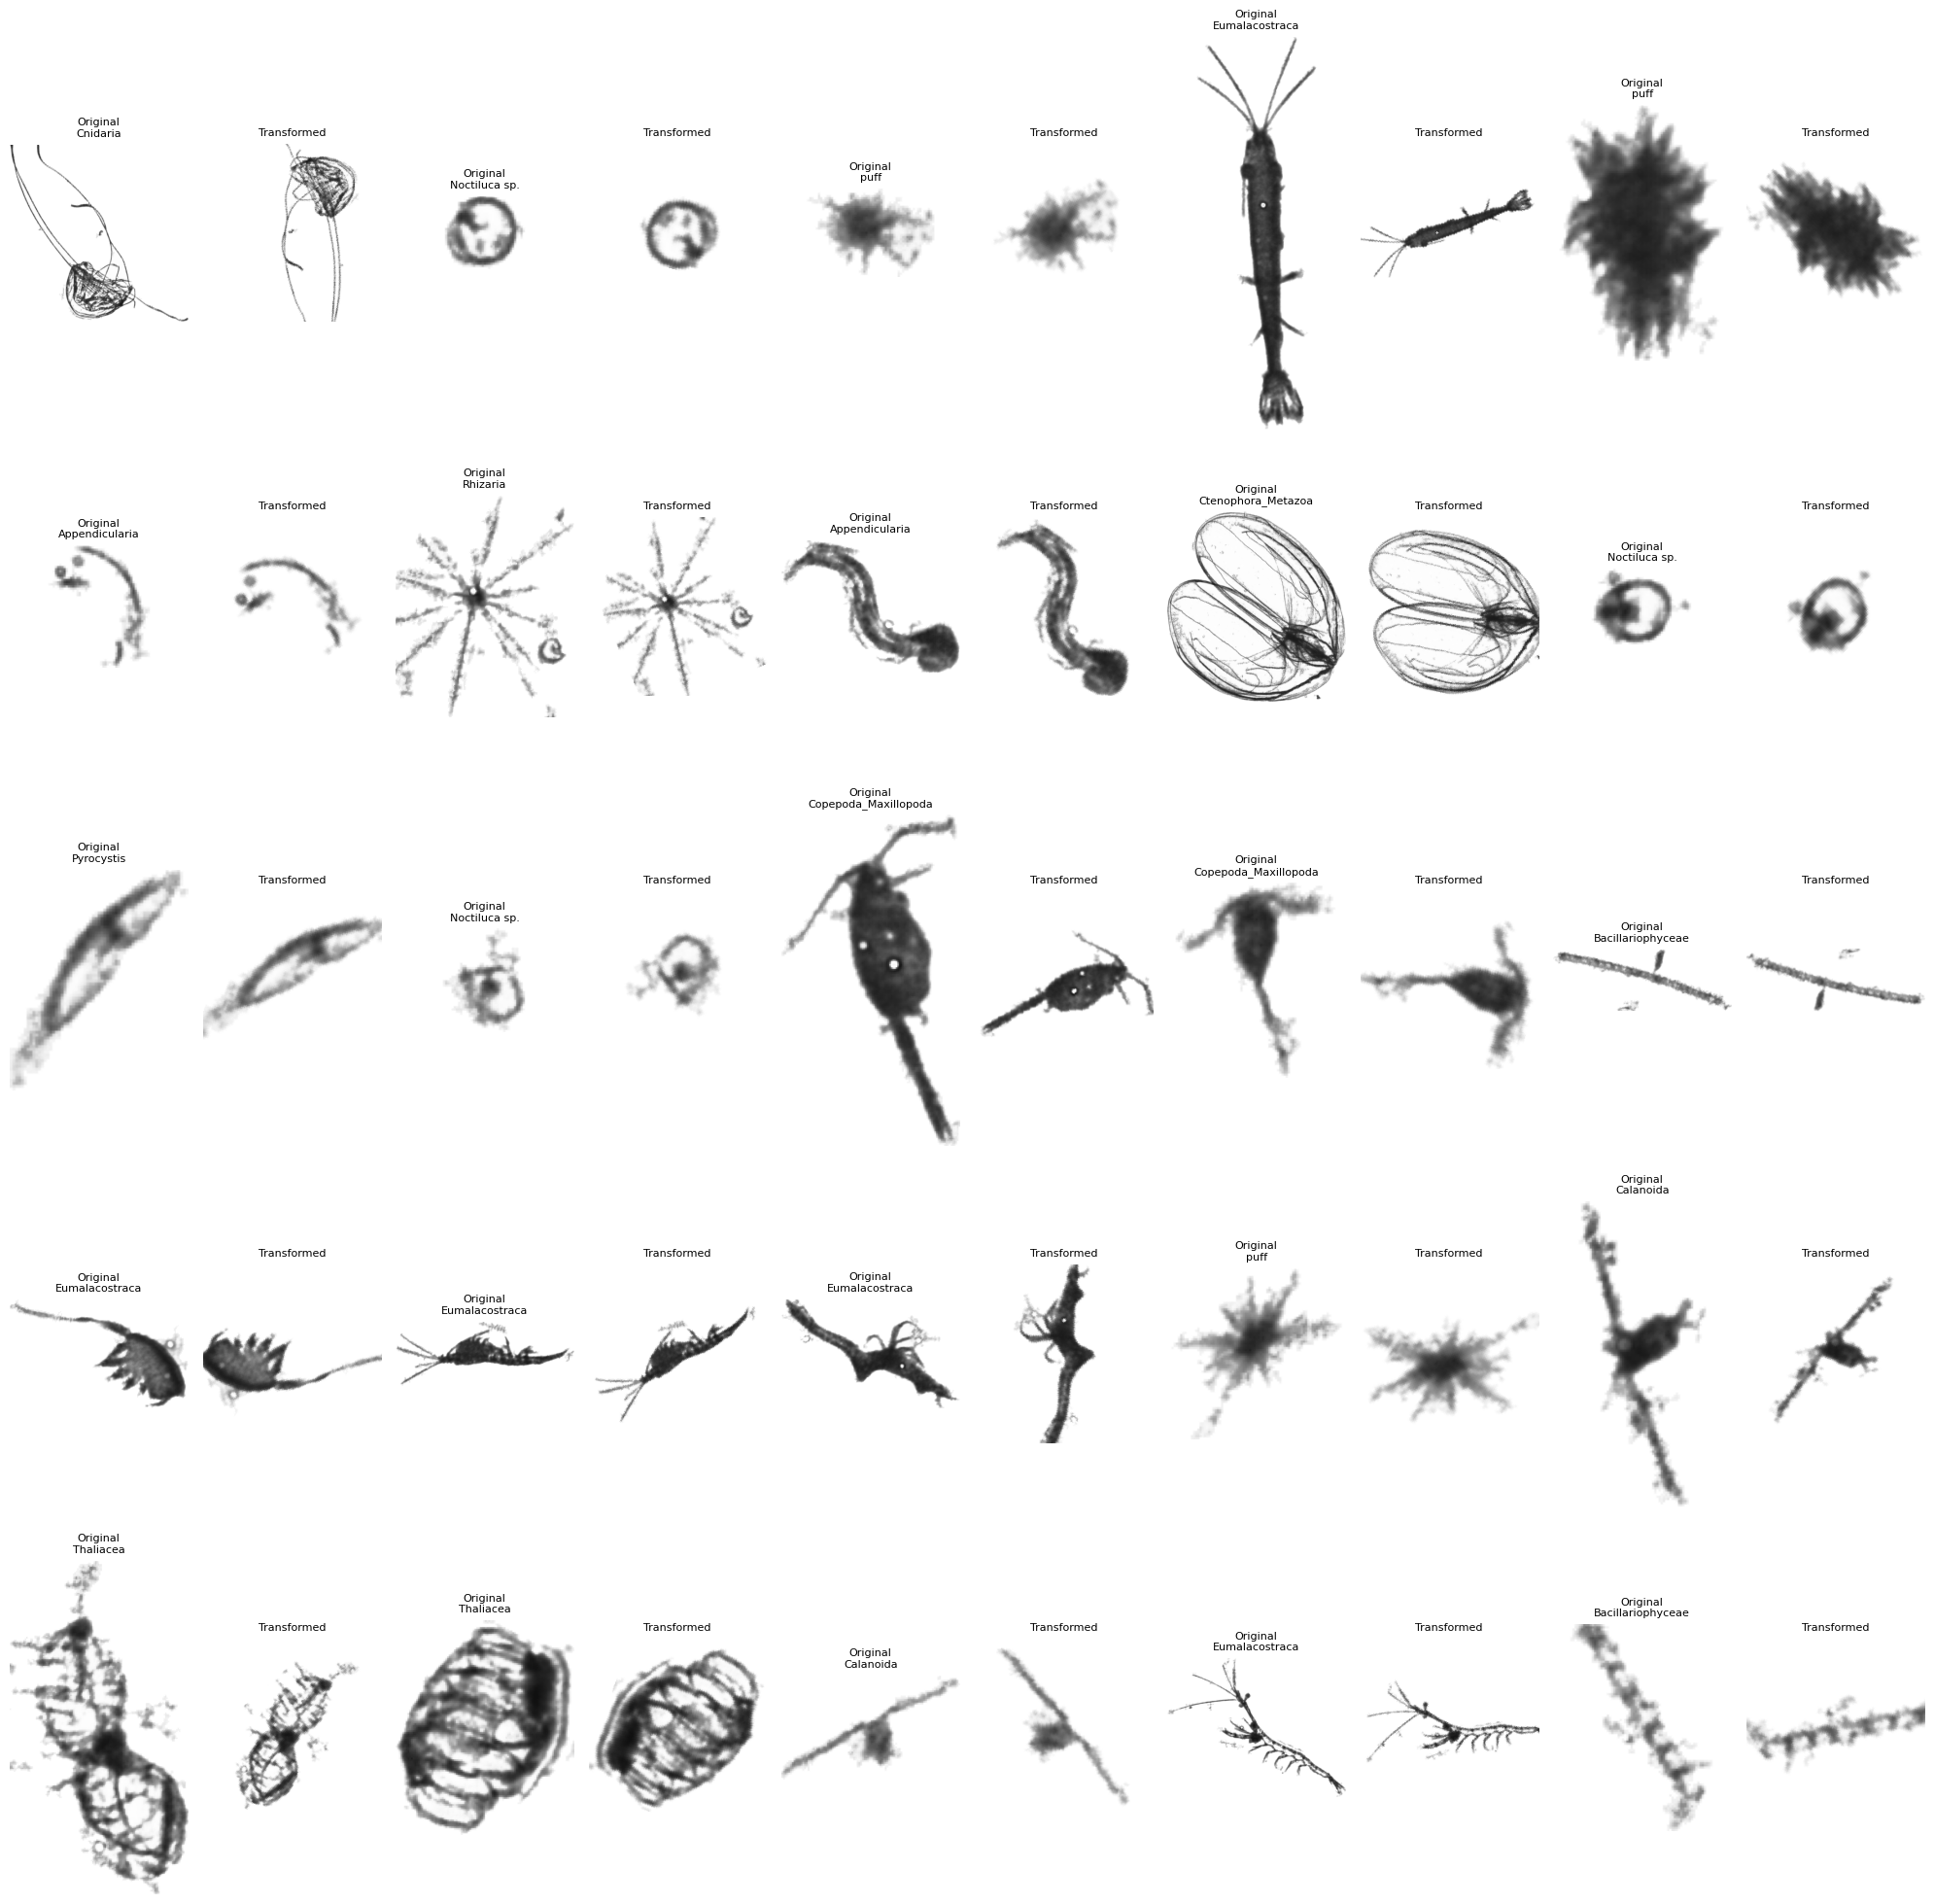

In [33]:
# Show the effect of the transformations that are applied to each image. Images will be shown in pairs: original and transformed.
# This is how the ViT will receive the images... sort of at least.

visualize_transformations(prepared_ds['train'], ds['train'])

## Setup of the ViT 

In [30]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
#model_name_or_path = '/home/veit/PIScO_dev/ViT_custom_size_sensitive_binary/best_model'

root_dir = "/home/veit/PIScO_dev/ViT_custom_size_sensitive_v4"  # Path where all config files and checkpoints will be saved

experiment with size channel.

In [58]:
def custom_image_processor(image, target_size=(224, 224), padding_color=255, size_bar=False, pixels_per_mm=43.48):
    """Process image and add physical size information for telecentric system
    
    Args:
        image: PIL Image
        target_size: Tuple of (height, width) for output size
        padding_color: Color value for padding
        size_bar: Boolean indicating if image has a scale bar to remove
        pixels_per_mm: Calibration factor for telecentric system
    
    Returns:
        torch.Tensor: 4-channel tensor (RGB + size channel) or None if processing fails
    """
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Calculate physical size before any transformations
    # Convert to binary (assuming object is darker than background)
    binary = (np.array(image) < 220).any(axis=2)
    # Calculate area in pixels
    pixel_area = np.count_nonzero(binary)
    # Convert to physical area (mm²)
    physical_area = pixel_area / (pixels_per_mm ** 2)
    # Calculate equivalent diameter (mm)
    physical_size = 2 * np.sqrt(physical_area / np.pi)
    
    if size_bar:
        # Remove scale bar by cropping the bottom 50 pixels
        width, height = image.size
        image = image.crop((0, 0, width, height - 50))

    # Step 1: Resize the image
    resized_image = resize_to_larger_edge(image, target_size[0])
    if resized_image is None:
        return None

    # Step 2: Calculate padding
    new_width, new_height = resized_image.size
    padding_left = (target_size[0] - new_width) // 2
    padding_right = target_size[0] - new_width - padding_left
    padding_top = (target_size[1] - new_height) // 2
    padding_bottom = target_size[1] - new_height - padding_top

    # Step 3: Apply padding
    padding = (padding_left, padding_top, padding_right, padding_bottom)
    pad_transform = transforms.Pad(padding, fill=padding_color)
    padded_image = pad_transform(resized_image)

    # Step 4: Apply image transformations
    transform_chain = transforms.Compose([
        transforms.RandomRotation(degrees=180, fill=padding_color),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Process RGB image
    image_tensor = transform_chain(padded_image)
    
    # Create size channel (normalized between 0 and 1)
    # Assuming plankton size range from 0.1mm to 10mm
    normalized_size = np.clip((physical_size - 0.1) / (10 - 0.1), 0, 1)
    size_tensor = torch.full((1, target_size[0], target_size[1]), normalized_size)
    
    # Combine RGB and size channels
    combined_tensor = torch.cat([image_tensor, size_tensor], dim=0)
    
    return combined_tensor

def process_batch(example_batch):
    """Process a batch of images with size information"""
    # Process each image in the batch
    processed_images = [
        custom_image_processor(img) 
        for img in example_batch['image']
        if custom_image_processor(img) is not None
    ]
    
    # Stack into batch tensor (B x 4 x H x W)
    inputs = torch.stack(processed_images)
    
    return {
        'pixel_values': inputs,
        'label': example_batch['label']
    }

from transformers import ViTPreTrainedModel, ViTModel
import torch.nn as nn

class SizeAwareViT(ViTPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.vit = ViTModel(config)
        
        # Ensure patch embeddings are configured for 4 channels
        self.vit.embeddings.patch_embeddings.num_channels = 4
        
        # Modify the first conv layer to accept 4 channels (RGB + size)
        old_weight = self.vit.embeddings.patch_embeddings.projection.weight
        new_weight = torch.zeros(
            old_weight.shape[0], 
            4,  # 3 RGB channels + 1 size channel
            old_weight.shape[2],
            old_weight.shape[3]
        )
        # Copy RGB weights - fixed dimension handling
        new_weight[:, :3, :, :] = old_weight[:, :3, :, :]  # Copy RGB channels
        # Initialize size channel weights
        new_weight[:, 3:, :, :] = old_weight[:, :1, :, :]  # Initialize size channel with first channel's weights
        
        # Replace the projection layer
        self.vit.embeddings.patch_embeddings.projection = nn.Conv2d(
            4, config.hidden_size, kernel_size=16, stride=16
        )
        self.vit.embeddings.patch_embeddings.projection.weight = nn.Parameter(new_weight)
        
        # Classification head
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values)
        logits = self.classifier(outputs.pooler_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        
        return (loss, logits) if loss is not None else logits

loading the ViT Model

In [ ]:
### This is the 4-channel ViT model that accepts RGB images with an additional size channel.
#############################################################################################

from transformers import ViTConfig

# Load the base configuration
config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
config.num_channels = 4  # Set number of input channels to 4 (RGB + size)
config.num_labels = len(labels)
config.id2label = {str(i): c for i, c in enumerate(labels)}
config.label2id = {c: str(i) for i, c in enumerate(labels)}

# Initialize our custom model with modified config
model = SizeAwareViT(config)

# Initialize with ImageNet pretrained weights where possible
base_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(labels),
    ignore_mismatched_sizes=True
)

# Copy weights from pretrained model where shapes match
pretrained_dict = base_model.state_dict()
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() 
                  if k in model_dict and v.shape == model_dict[k].shape}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# The first conv layer and classifier will keep their random initialization
# since their shapes don't match the pretrained model

def collate_fn(batch):
    """Collate batch with support for SizeAwareViT's 4-channel tensors"""
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),  # Now stacks 4-channel tensors
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = evaluate.load("precision_recall_fscore_support")

def compute_metrics(p):
    """Compute metrics stays exactly the same since we're still doing classification"""
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
### This is the normal ViT model that accepts RGB images.
#############################################################################################

#processor = AutoImageProcessor.from_pretrained(model_name_or_path, use_fast=True)

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = evaluate.load("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Set up the training arguments
training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=16,
  eval_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=30,
  logging_steps=500,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,

)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    
    #tokenizer=processor,
)

In [13]:
# Print GPU information
print("Available GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")

# Select specific GPU
#torch.cuda.set_device(0)  # Use GPU 0
#print(f"Using GPU: {torch.cuda.current_device()}")

Available GPUs: 1
GPU 0: Radeon RX 7900 XTX
Memory: 25.75 GB


Input shape: torch.Size([16, 4, 224, 224])
Expected shape: [batch_size, channels, height, width]
Number of channels: 4
Labels shape: torch.Size([16])


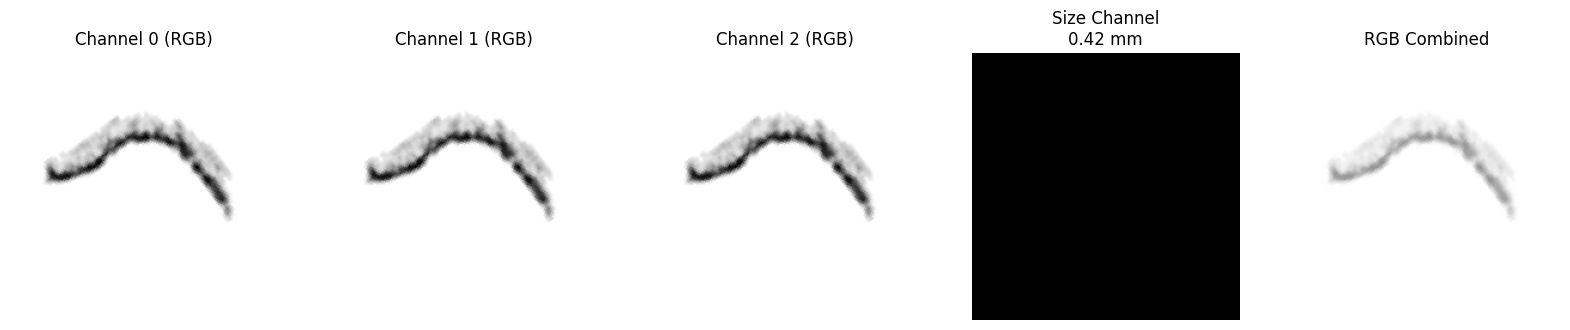

In [61]:
# Check data shapes
sample_batch = next(iter(DataLoader(prepared_ds["train"], batch_size=16, collate_fn=collate_fn)))
print("Input shape:", sample_batch['pixel_values'].shape)
print("Expected shape: [batch_size, channels, height, width]")
print("Number of channels:", sample_batch['pixel_values'].size(1))
print("Labels shape:", sample_batch['labels'].shape)

# Visualize one sample with all channels
sample_image = sample_batch['pixel_values'][1]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# RGB channels
for i in range(3):
    axes[i].imshow(sample_image[i].numpy(), cmap='gray')
    axes[i].set_title(f'Channel {i} (RGB)')
    axes[i].axis('off')

# Size channel
size_channel = sample_image[3].numpy()
# Convert normalized size back to physical size in mm
physical_size = (size_channel.mean() * (10 - 0.1)) + 0.1  # Reverse the normalization
axes[3].imshow(size_channel, cmap='gray')
axes[3].set_title(f'Size Channel\n{physical_size:.2f} mm')
axes[3].axis('off')

# Combined RGB
axes[4].imshow(sample_image[:3].permute(1, 2, 0).numpy() * 0.5 + 0.5)
axes[4].set_title('RGB Combined')
axes[4].axis('off')

plt.show()

### Start of training

Training history:
1. trained on ecotaxa export from Fanny's annotations 20 epochs (earlier Version): /home/veit/PIScO_dev/ViT_custom_size_sensitive
2. trained on export transferred to raw images 25 epochs: /home/veit/PIScO_dev/ViT_custom_size_sensitive_raw
3. retrained (1) on validated and reinforced export, 25 epochs => merged dataset (inference on full profile 050, validated/annotated with focus on high entropy predictions): /home/veit/PIScO_dev/ViT_custom_size_sensitive_v2
4. retrained (3) on binary (living - non-living) dataset 20 epochs: /home/veit/PIScO_dev/ViT_custom_size_sensitive_binary

In [34]:
save_dir = os.path.join(root_dir, 'best_model')  # Define the path to save the model
train_results = trainer.train()
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/veit/miniconda3/envs/pisco/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Using AOTriton backend for Flash Attention backward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/flash_attn/flash_api.h:452.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


***** train metrics *****
  epoch                    =          30.0
  total_flos               = 11543602663GF
  train_loss               =         0.137
  train_runtime            =    0:20:03.76
  train_samples_per_second =       132.858
  train_steps_per_second   =         8.324


## Analysis of the training. 
### Metrics and visualization 

In [35]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

test_ds = ds['test'].with_transform(process_batch)
test_outputs = trainer.predict(test_ds)


***** test metrics *****
  epoch                   =       30.0
  eval_accuracy           =     0.9229
  eval_loss               =     0.2398
  eval_runtime            = 0:00:06.86
  eval_samples_per_second =    259.114
  eval_steps_per_second   =     32.499


In [ ]:
from sklearn.metrics import precision_score, f1_score, classification_report

# Get predictions and true labels
y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

# Calculate metrics
precision = precision_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Print detailed metrics for each class as a markdown table
labels = test_ds.features["label"].names

# Calculate recall for each class using the confusion matrix
cm = confusion_matrix(y_true, y_pred)
recalls = [cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0.0 for i in range(len(labels))]

# Build markdown table
md = "| Class | Precision | Recall | F1-Score |\n"
md += "|-------|-----------|--------|----------|\n"
for i, label in enumerate(labels):
    md += f"| {label} | {precision[i]:.3f} | {recalls[i]:.3f} | {f1[i]:.3f} |\n"

# Add overall metrics
macro_precision = precision.mean()
macro_recall = np.mean(recalls)
macro_f1 = f1.mean()
md += f"\n**Overall Metrics:**\n\n"
md += f"| Macro-averaged Precision | Macro-averaged Recall | Macro-averaged F1-Score |\n"
md += f"|-------------------------|-----------------------|-------------------------|\n"
md += f"| {macro_precision:.3f} | {macro_recall:.3f} | {macro_f1:.3f} |\n"

# Print the markdown table
print(md)

# Optional: Print full classification report
#print("\nClassification Report:")
#print("-" * 80)
#print(classification_report(y_true, y_pred, target_names=labels))


Detailed Classification Metrics:
--------------------------------------------------------------------------------

Class: Asteroidea larvae
Precision: 0.950
Recall: 0.950
F1-Score: 0.950

Class: Bacillariophyceae
Precision: 0.957
Recall: 1.000
F1-Score: 0.978

Class: Calanoida
Precision: 0.800
Recall: 0.901
F1-Score: 0.848

Class: Chaetognatha
Precision: 0.990
Recall: 0.893
F1-Score: 0.939

Class: Copepoda_Maxillopoda
Precision: 0.878
Recall: 0.829
F1-Score: 0.853

Class: Ctenophora_Metazoa
Precision: 0.812
Recall: 0.684
F1-Score: 0.743

Class: Noctiluca sp.
Precision: 0.983
Recall: 0.983
F1-Score: 0.983

Class: Oithona
Precision: 0.915
Recall: 0.935
F1-Score: 0.925

Class: Pyrocystis
Precision: 0.600
Recall: 0.900
F1-Score: 0.720

Class: Rhizaria
Precision: 0.932
Recall: 0.960
F1-Score: 0.946

Class: puff
Precision: 0.975
Recall: 0.940
F1-Score: 0.957

Class: tuft
Precision: 0.989
Recall: 0.948
F1-Score: 0.968

Class: Appendicularia
Precision: 0.933
Recall: 0.980
F1-Score: 0.956

Cla

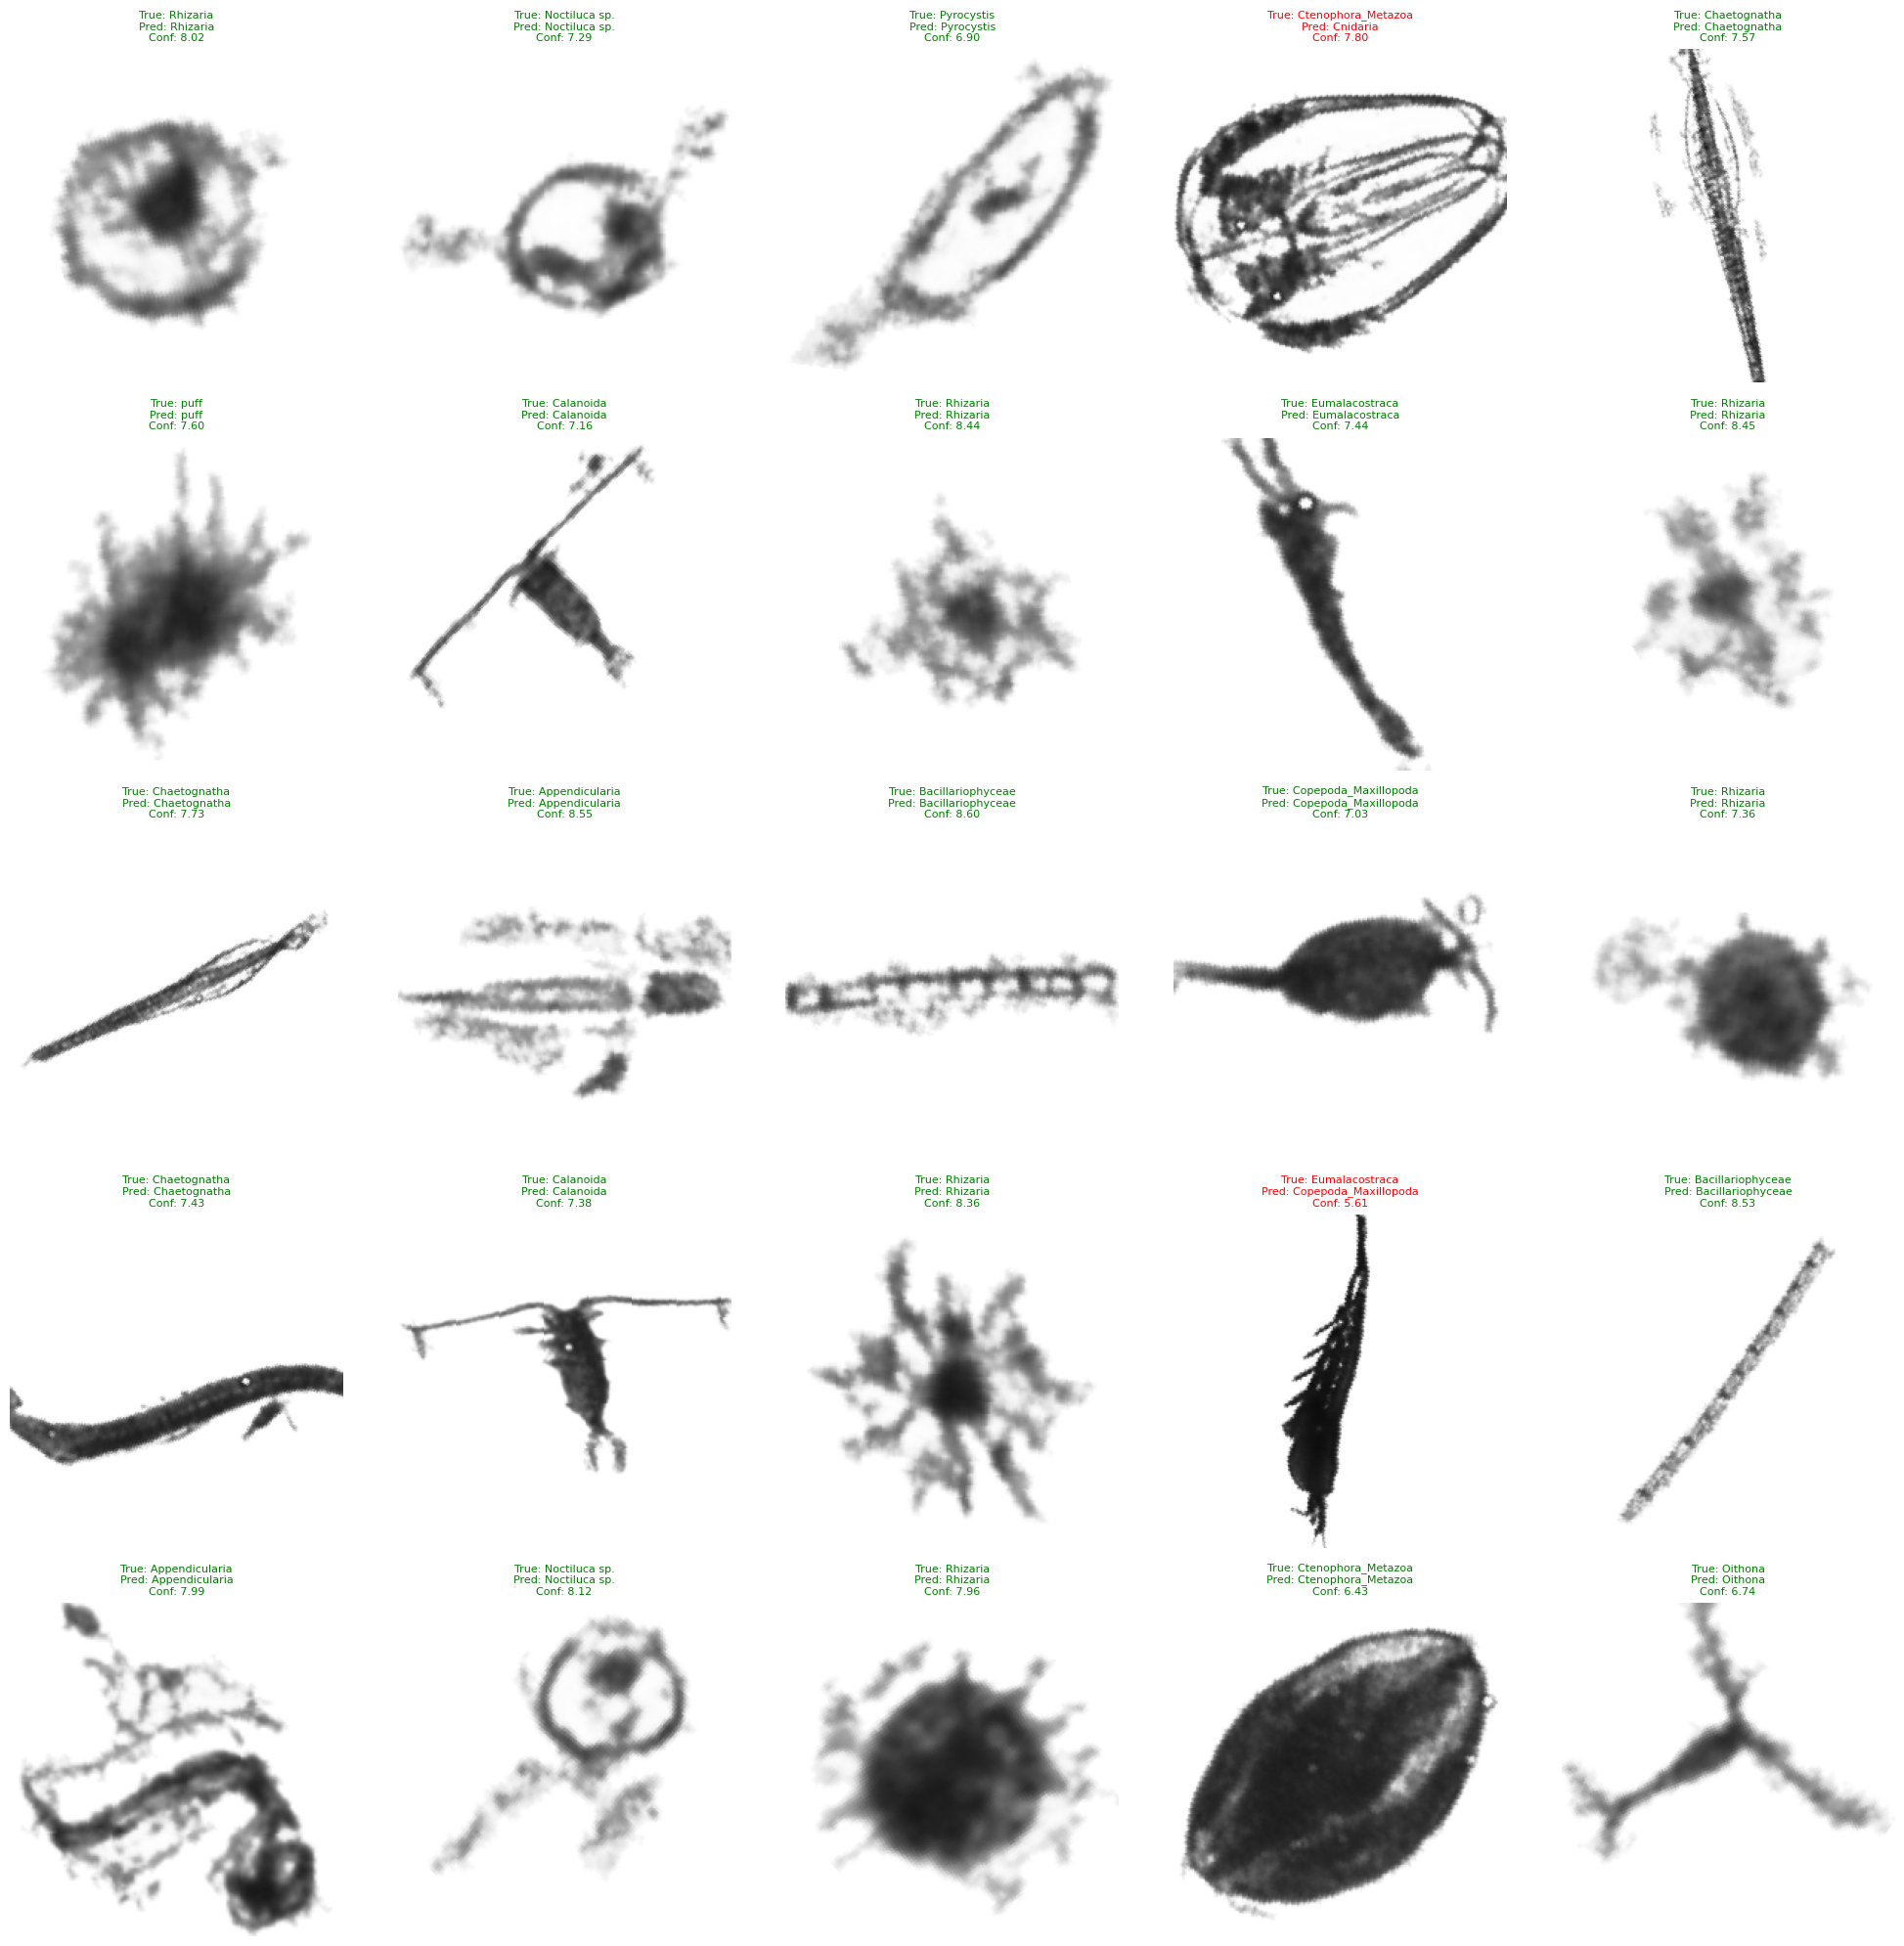


Overall Accuracy: 92.69%


In [36]:
def visualize_predictions(test_outputs, dataset, num_samples=25, rows=5, cols=5):
    """
    Visualize random samples with their true and predicted labels.
    
    Args:
        model: Trained ViT model
        dataset: Dataset with transformed images
        num_samples: Number of samples to visualize
        rows: Number of rows in the grid
        cols: Number of columns in the grid
    """
    # Get predictions for the whole dataset
    predictions = test_outputs.predictions.argmax(1)
    
    # Get random indices
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    # Get label names
    label_names = dataset.features['label'].names
    
    for idx, sample_idx in enumerate(random_indices):
        # Get original image and prediction
        sample = dataset[sample_idx]
        true_label = label_names[sample['label']]
        pred_label = label_names[predictions[sample_idx]]
        
        # Get confidence score
        confidence = test_outputs.predictions[sample_idx].max()
        
        # Create color for title based on correct/incorrect prediction
        title_color = 'green' if true_label == pred_label else 'red'
        
        # Plot the image
        plt.subplot(rows, cols, idx + 1)
        # Convert tensor to image for display
        img = sample['pixel_values'].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(img)
        
        # Add title with true and predicted labels
        title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}'
        plt.title(title, color=title_color, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Print overall accuracy
    accuracy = (predictions == test_outputs.label_ids).mean()
    print(f"\nOverall Accuracy: {accuracy:.2%}")

# Visualize predictions on the test set
visualize_predictions(test_outputs, test_ds, num_samples=25, rows=5, cols=5)

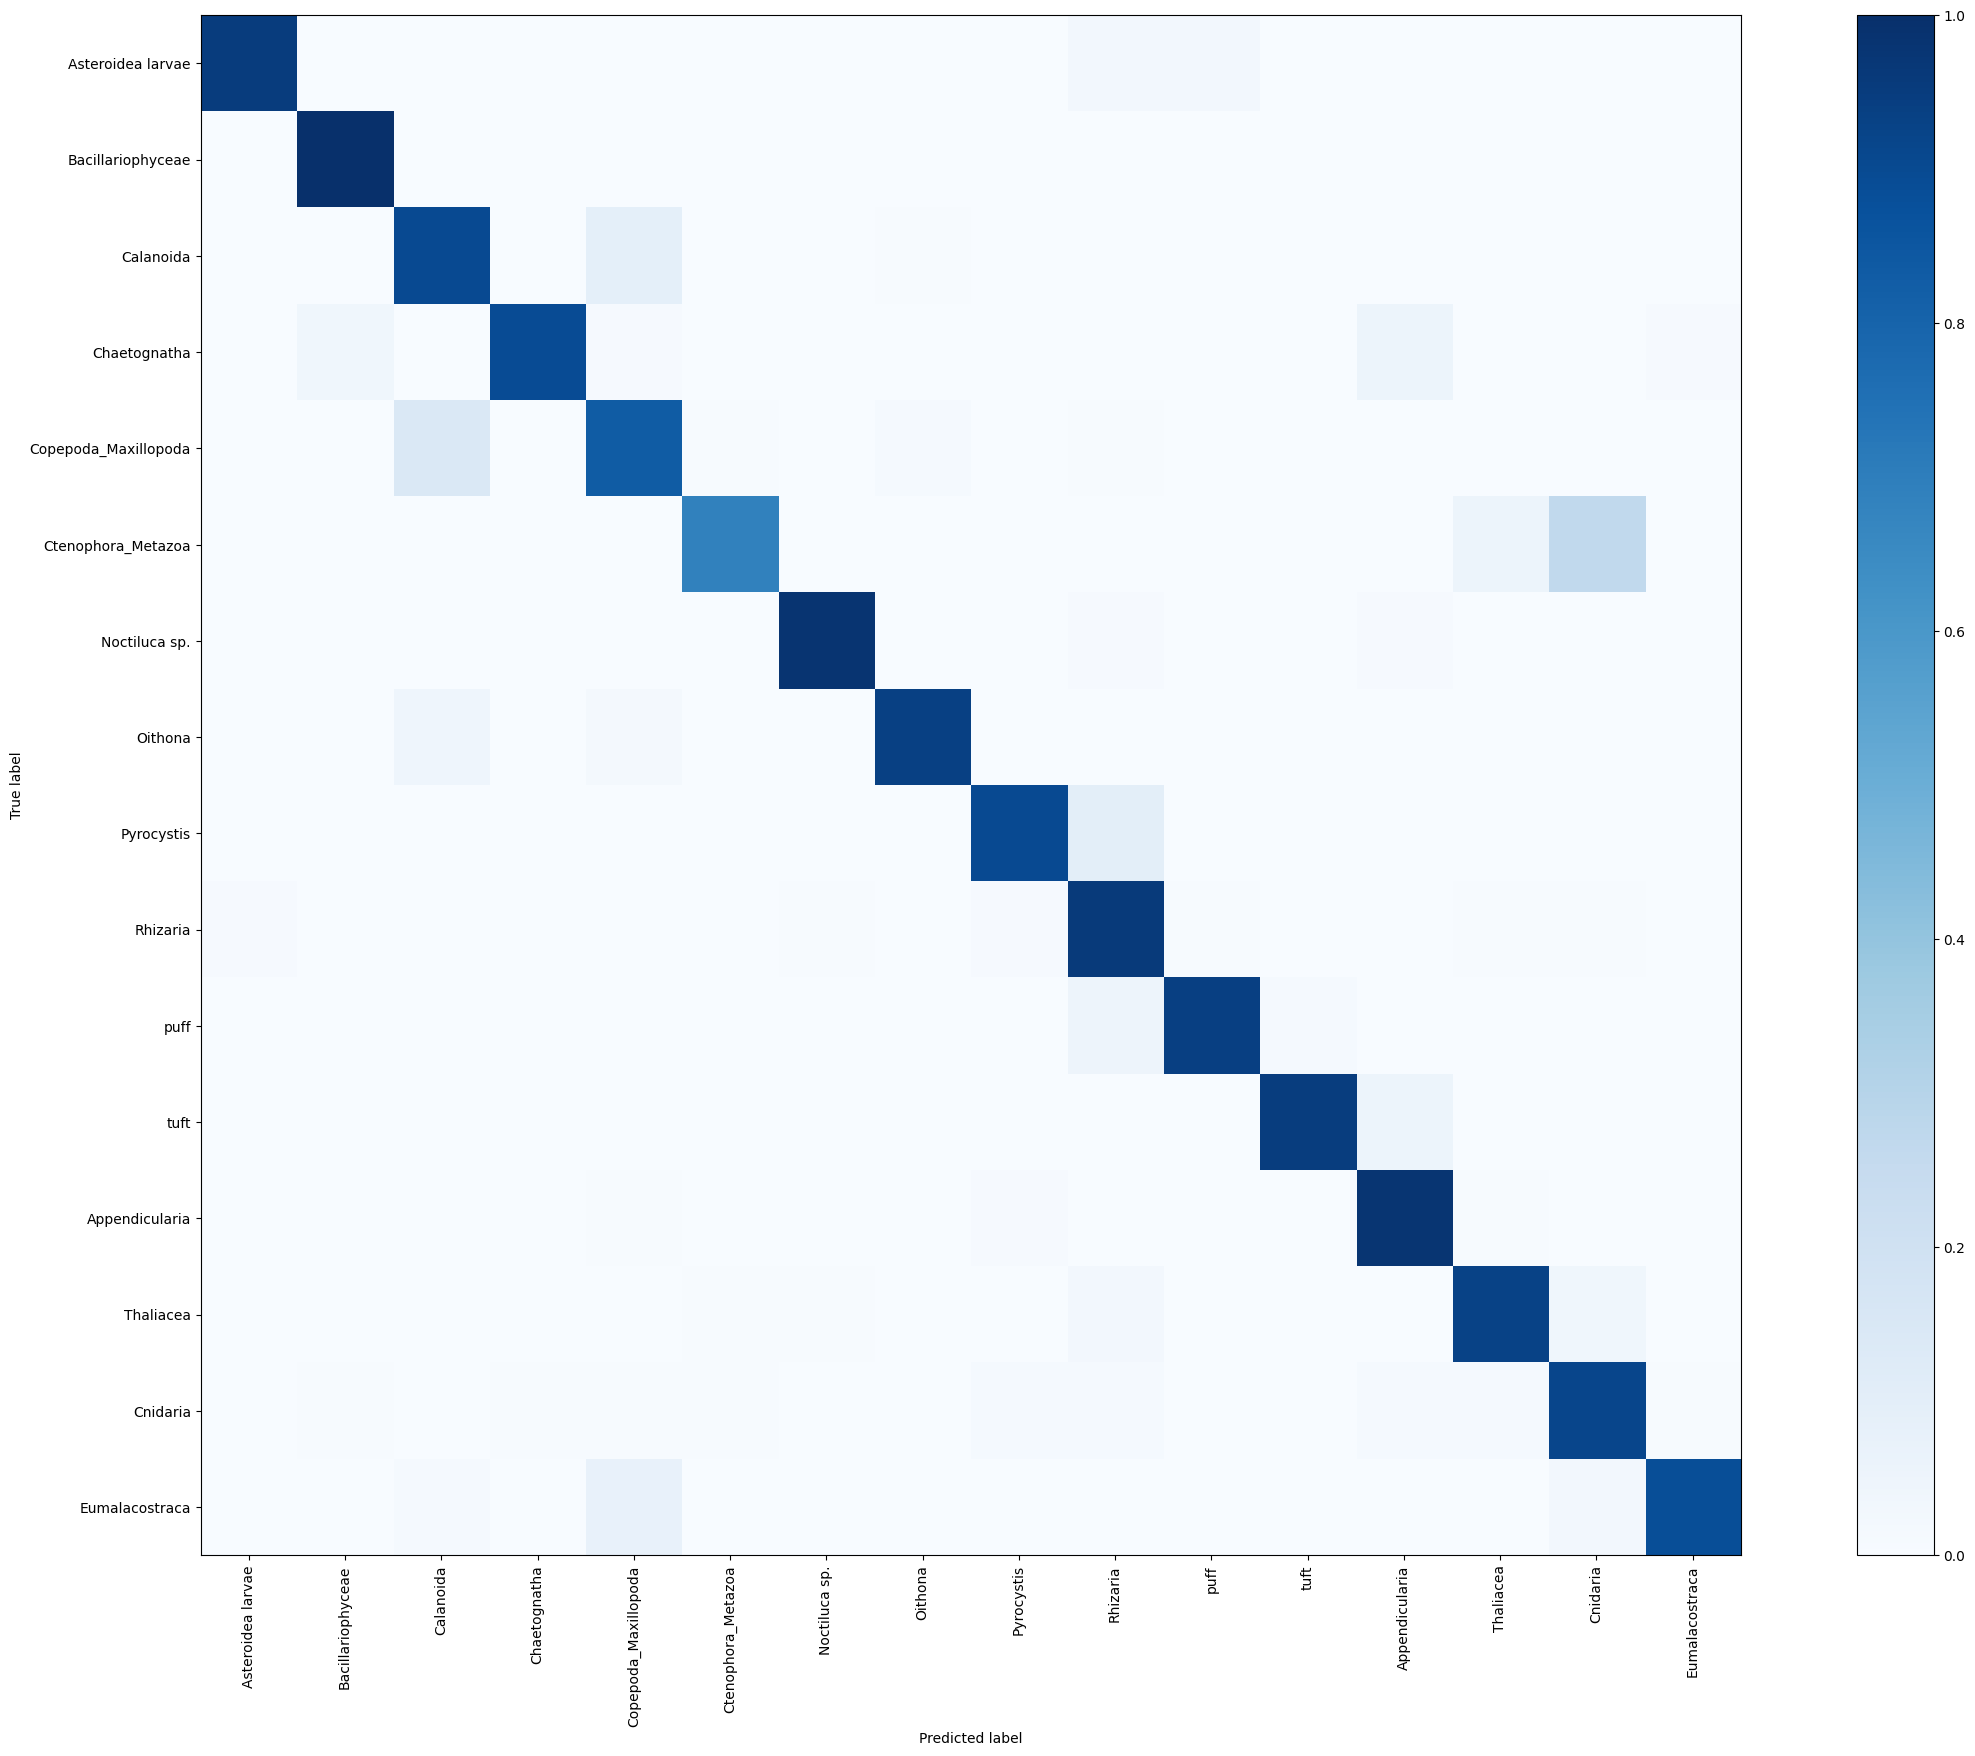


Class-wise Analysis:
--------------------------------------------------------------------------------

Class: Asteroidea larvae
Recall: 0.95
Most confused with:
  - Rhizaria: 2.50%
  - puff: 2.50%

Class: Bacillariophyceae
Recall: 1.00
Most confused with:

Class: Calanoida
Recall: 0.90
Most confused with:
  - Copepoda_Maxillopoda: 9.15%
  - Oithona: 0.70%

Class: Chaetognatha
Recall: 0.89
Most confused with:
  - Appendicularia: 5.36%
  - Bacillariophyceae: 3.57%
  - Copepoda_Maxillopoda: 0.89%

Class: Copepoda_Maxillopoda
Recall: 0.83
Most confused with:
  - Calanoida: 14.57%
  - Oithona: 1.51%
  - Rhizaria: 0.50%

Class: Ctenophora_Metazoa
Recall: 0.68
Most confused with:
  - Cnidaria: 26.32%
  - Thaliacea: 5.26%

Class: Noctiluca sp.
Recall: 0.98
Most confused with:
  - Appendicularia: 0.83%
  - Rhizaria: 0.83%

Class: Oithona
Recall: 0.93
Most confused with:
  - Calanoida: 4.35%
  - Copepoda_Maxillopoda: 2.17%

Class: Pyrocystis
Recall: 0.90
Most confused with:
  - Rhizaria: 10.00%

In [37]:
# Calculate and visualize confusion matrix

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a larger figure
fig, ax = plt.subplots(figsize=(30, 20))  # Create a figure and a set of subplots with specified size

# Define a colormap
cmap = plt.get_cmap('Blues')

# Create the confusion matrix display with normalized values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)

# Plot the confusion matrix
disp.plot(cmap=cmap, xticks_rotation='vertical', values_format='.2f', ax=ax)
# Remove the annotations
for text in disp.text_.ravel():
    text.set_visible(False)

# Show the plot
plt.show()

# # Calculate recall for each class
# recall = recall_score(y_true, y_pred, average=None)

# # Print the recall for each class
# for label, score in zip(labels, recall):
#   print(f"Recall for {label}: {score:.2f}")
# Calculate recall for each class and find most confused categories
print("\nClass-wise Analysis:")
print("-" * 80)
for i, label in enumerate(labels):
    # Calculate recall
    recall = cm[i, i] / cm[i].sum()
    
    # Find the most confused categories (excluding self-predictions)
    confusion_scores = cm_normalized[i]
    confusion_scores[i] = 0  # Exclude self-predictions
    most_confused_idx = np.argsort(confusion_scores)[-3:][::-1]  # Get top 3 confused categories
    
    print(f"\nClass: {label}")
    print(f"Recall: {recall:.2f}")
    print("Most confused with:")
    for idx in most_confused_idx:
        if confusion_scores[idx] > 0:  # Only show if there's actual confusion
            print(f"  - {labels[idx]}: {confusion_scores[idx]:.2%}")
print("-" * 80)

# Inference on test profile

In [44]:
def load_unclassified_images(data_dir):
    """
    Load unclassified images from a directory, filtering for valid image files.
    
    Args:
        data_dir (str): Path to directory containing images
        
    Returns:
        Dataset: HuggingFace dataset containing images
    """
    # Define valid image extensions
    valid_extensions = ('.jpg', '.jpeg', '.png', '.tif', '.tiff')
    
    # List all files in the directory and filter for valid image files
    image_files = [
        os.path.join(data_dir, f) 
        for f in os.listdir(data_dir) 
        if os.path.isfile(os.path.join(data_dir, f))
        and f.lower().endswith(valid_extensions)
    ]

    # Prepare data for the dataset
    data = {
        'image': image_files,
        'label': image_files 
    }
    
    features = Features({
        'image': ImageFeature(),
        'label': Value('string')
    })
    
    # Create the dataset
    dataset = Dataset.from_dict(data, features=features)
    return dataset


def get_predictions_on_dataset_in_batches(dataset, save_dir, batch_size=64):
    print("Initializing model for predictions")
    vit = ViTForImageClassification.from_pretrained(save_dir)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit.to(device)
    vit.eval()  # Ensure model is in eval mode
    
    # Optimize DataLoader
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,  # Parallel data loading
        pin_memory=True,  # Faster CPU to GPU transfer
        prefetch_factor=2  # Prefetch batches
    )
    
    predictions = []
    filenames = []
    probabilities = []
    
    with torch.amp.autocast('cuda'):  # Enable automatic mixed precision
        for batch in tqdm(dataloader, desc="Processing dataset"):
            # Batch processing in one go
            inputs = batch['pixel_values'].to(device, non_blocking=True)
            
            with torch.no_grad():
                outputs = vit(pixel_values=inputs)
            
            # Process predictions efficiently
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            top_probs, top_indices = torch.topk(probs, 5, dim=-1)
            
            # Batch process labels
            batch_labels = [[vit.config.id2label[idx.item()] for idx in indices] 
                          for indices in top_indices]
            
            predictions.extend(batch_labels)
            filenames.extend(batch['label'])
            probabilities.extend(top_probs.cpu().numpy())
    
    print(f"Predictions completed for {len(filenames)} images")
    return filenames, predictions, probabilities

def get_predictions_with_entropy_ood(dataset, save_dir, entropy_threshold=1.0, temperature=1.5, batch_size=64):
    print("Initializing model for predictions")
    vit = ViTForImageClassification.from_pretrained(save_dir)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit.to(device)
    vit.eval()
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2
    )
    
    predictions = []
    filenames = []
    probabilities = []
    entropy_scores = []
    ood_flags = []
    
    with torch.amp.autocast('cuda'):
        for batch in tqdm(dataloader, desc="Processing dataset"):
            inputs = batch['pixel_values'].to(device, non_blocking=True)
            
            with torch.no_grad():
                outputs = vit(pixel_values=inputs)
            
            # Apply temperature scaling
            scaled_logits = outputs.logits / temperature
            probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
            
            # Calculate entropy
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            
            top_probs, top_indices = torch.topk(probs, 5, dim=-1)
            
            batch_labels = [[vit.config.id2label[idx.item()] for idx in indices] 
                          for indices in top_indices]
            
            # Flag samples as OOD if entropy is above threshold
            batch_ood = (entropy > entropy_threshold).cpu().numpy()
            
            predictions.extend(batch_labels)
            filenames.extend(batch['label'])
            probabilities.extend(top_probs.cpu().numpy())
            entropy_scores.extend(entropy.cpu().numpy())
            ood_flags.extend(batch_ood)
    
    return filenames, predictions, probabilities, entropy_scores, ood_flags

def custom_image_processor(image, target_size=(224, 224), padding_color=255, size_bar=False):
    if image.mode != 'RGB':
        image = image.convert('RGB')

    if size_bar:
        # Step 0: Remove scale bar by cropping the bottom 50 pixels
        width, height = image.size
        image = image.crop((0, 0, width, height - 50))  # Crop out the scale bar area
    
    # Step 1: Resize the image
    resized_image = resize_to_larger_edge(image,224)

    if resized_image is None:  # Skip processing if resizing failed
        #print(f"Skipping image due to resize failure: {image.size}")
        return None  # This allows to filter out bad images later

    #Step 2: Calculate padding
    new_width, new_height = resized_image.size
    padding_left = (target_size[0] - new_width) // 2
    padding_right = target_size[0] - new_width - padding_left
    padding_top = (target_size[1] - new_height) // 2
    padding_bottom = target_size[1] - new_height - padding_top

    # Step 3: Apply padding
    padding = (padding_left, padding_top, padding_right, padding_bottom)
    pad_transform = transforms.Pad(padding, fill=padding_color)
    padded_image = pad_transform(resized_image)

    # Step 4: Apply other transformations
    transform_chain = transforms.Compose([
        transforms.RandomRotation(degrees=180,fill=255),
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    ])
    
    # Apply the transformations
    return transform_chain(padded_image)

def get_predictions_with_entropy_ood_binary(dataset, save_dir, entropy_threshold=1.0, temperature=1.5, batch_size=64):
    """
    Get predictions with OOD detection for binary classifier
    """
    print("Initializing model for predictions")
    # Load binary classifier model
    vit = ViTForImageClassification.from_pretrained(save_dir)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit.to(device)
    vit.eval()
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2
    )
    
    predictions = []
    filenames = []
    probabilities = []
    entropy_scores = []
    ood_flags = []
    
    with torch.amp.autocast('cuda'):
        for batch in tqdm(dataloader, desc="Processing dataset"):
            inputs = batch['pixel_values'].to(device, non_blocking=True)
            
            with torch.no_grad():
                outputs = vit(pixel_values=inputs)
            
            # Apply temperature scaling
            scaled_logits = outputs.logits / temperature
            probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
            
            # Calculate entropy (for binary, max entropy is ln(2) ≈ 0.693)
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            
            # For binary classification, we only need top 1
            top_probs, top_indices = torch.max(probs, dim=-1)
            
            # Get predicted labels
            batch_labels = [[vit.config.id2label[idx.item()]] 
                        for idx in top_indices]
            
            # Flag samples as OOD if entropy is above threshold
            # For binary classification, you might want to lower the threshold
            batch_ood = (entropy > entropy_threshold).cpu().numpy()
            
            predictions.extend(batch_labels)
            filenames.extend(batch['label'])
            probabilities.extend(top_probs.unsqueeze(-1).cpu().numpy())  # Make it 2D
            entropy_scores.extend(entropy.cpu().numpy())
            ood_flags.extend(batch_ood)
    
    return filenames, predictions, probabilities, entropy_scores, ood_flags

In [ ]:
img_dir = "/home/veit/PIScO_dev/Segmentation_results/M181/M181-175-1_CTD-050_00°00S-019°00W_20220509-0543/Deconv_crops"  # Replace with your actual path to unclassified images
ds_pisco = load_unclassified_images(img_dir)

destination_path = '/home/veit/PIScO_dev/ViT_custom_size_sensitive/predictions'
os.makedirs(destination_path, exist_ok=True)

# Apply the transform to the dataset
ds_pisco_trans = ds_pisco.with_transform(process_batch)

# Define model name and path to the saved model
model_dir = '/home/veit/PIScO_dev/ViT_custom_size_sensitive_binary/best_model'

# Get predictions on the dataset in batches
#filenames, predictions, probabilities = get_predictions_on_dataset_in_batches(ds_pisco_trans, model_dir, batch_size=64)
# Using entropy-based OOD detection
filenames, predictions, probabilities, entropy_scores, ood_flags = get_predictions_with_entropy_ood_binary(
    ds_pisco_trans, 
    model_dir, 
    entropy_threshold=0.5,  # Tune this threshold
    temperature=1.5,        # Tune this parameter
    batch_size=64
)
  
# Create DataFrame with OOD detection results
df = pd.DataFrame({
    'filename': filenames,
    'is_ood': ood_flags,
    'entropy': entropy_scores,
    'top1': [pred[0] for pred in predictions],
    'prob1': [prob[0] for prob in probabilities],
})
result_path = os.path.join(destination_path, 'ViT_predictions.csv')
df.to_csv(result_path, index=False)
print("Predictions saved!")

# Print the first 5 predictions
print(df.head())

Initializing model for predictions


Processing dataset: 100%|██████████| 1644/1644 [01:29<00:00, 18.41it/s]


Predictions saved!
                                            filename  is_ood   entropy  \
0  /home/veit/PIScO_dev/Segmentation_results/M181...   False  0.630609   
1  /home/veit/PIScO_dev/Segmentation_results/M181...   False  0.017959   
2  /home/veit/PIScO_dev/Segmentation_results/M181...   False  0.044331   
3  /home/veit/PIScO_dev/Segmentation_results/M181...   False  0.686662   
4  /home/veit/PIScO_dev/Segmentation_results/M181...   False  0.193527   

         top1     prob1  
0  non_living  0.674962  
1      living  0.997419  
2  non_living  0.992467  
3  non_living  0.556882  
4  non_living  0.951684  



Visualizing all samples:


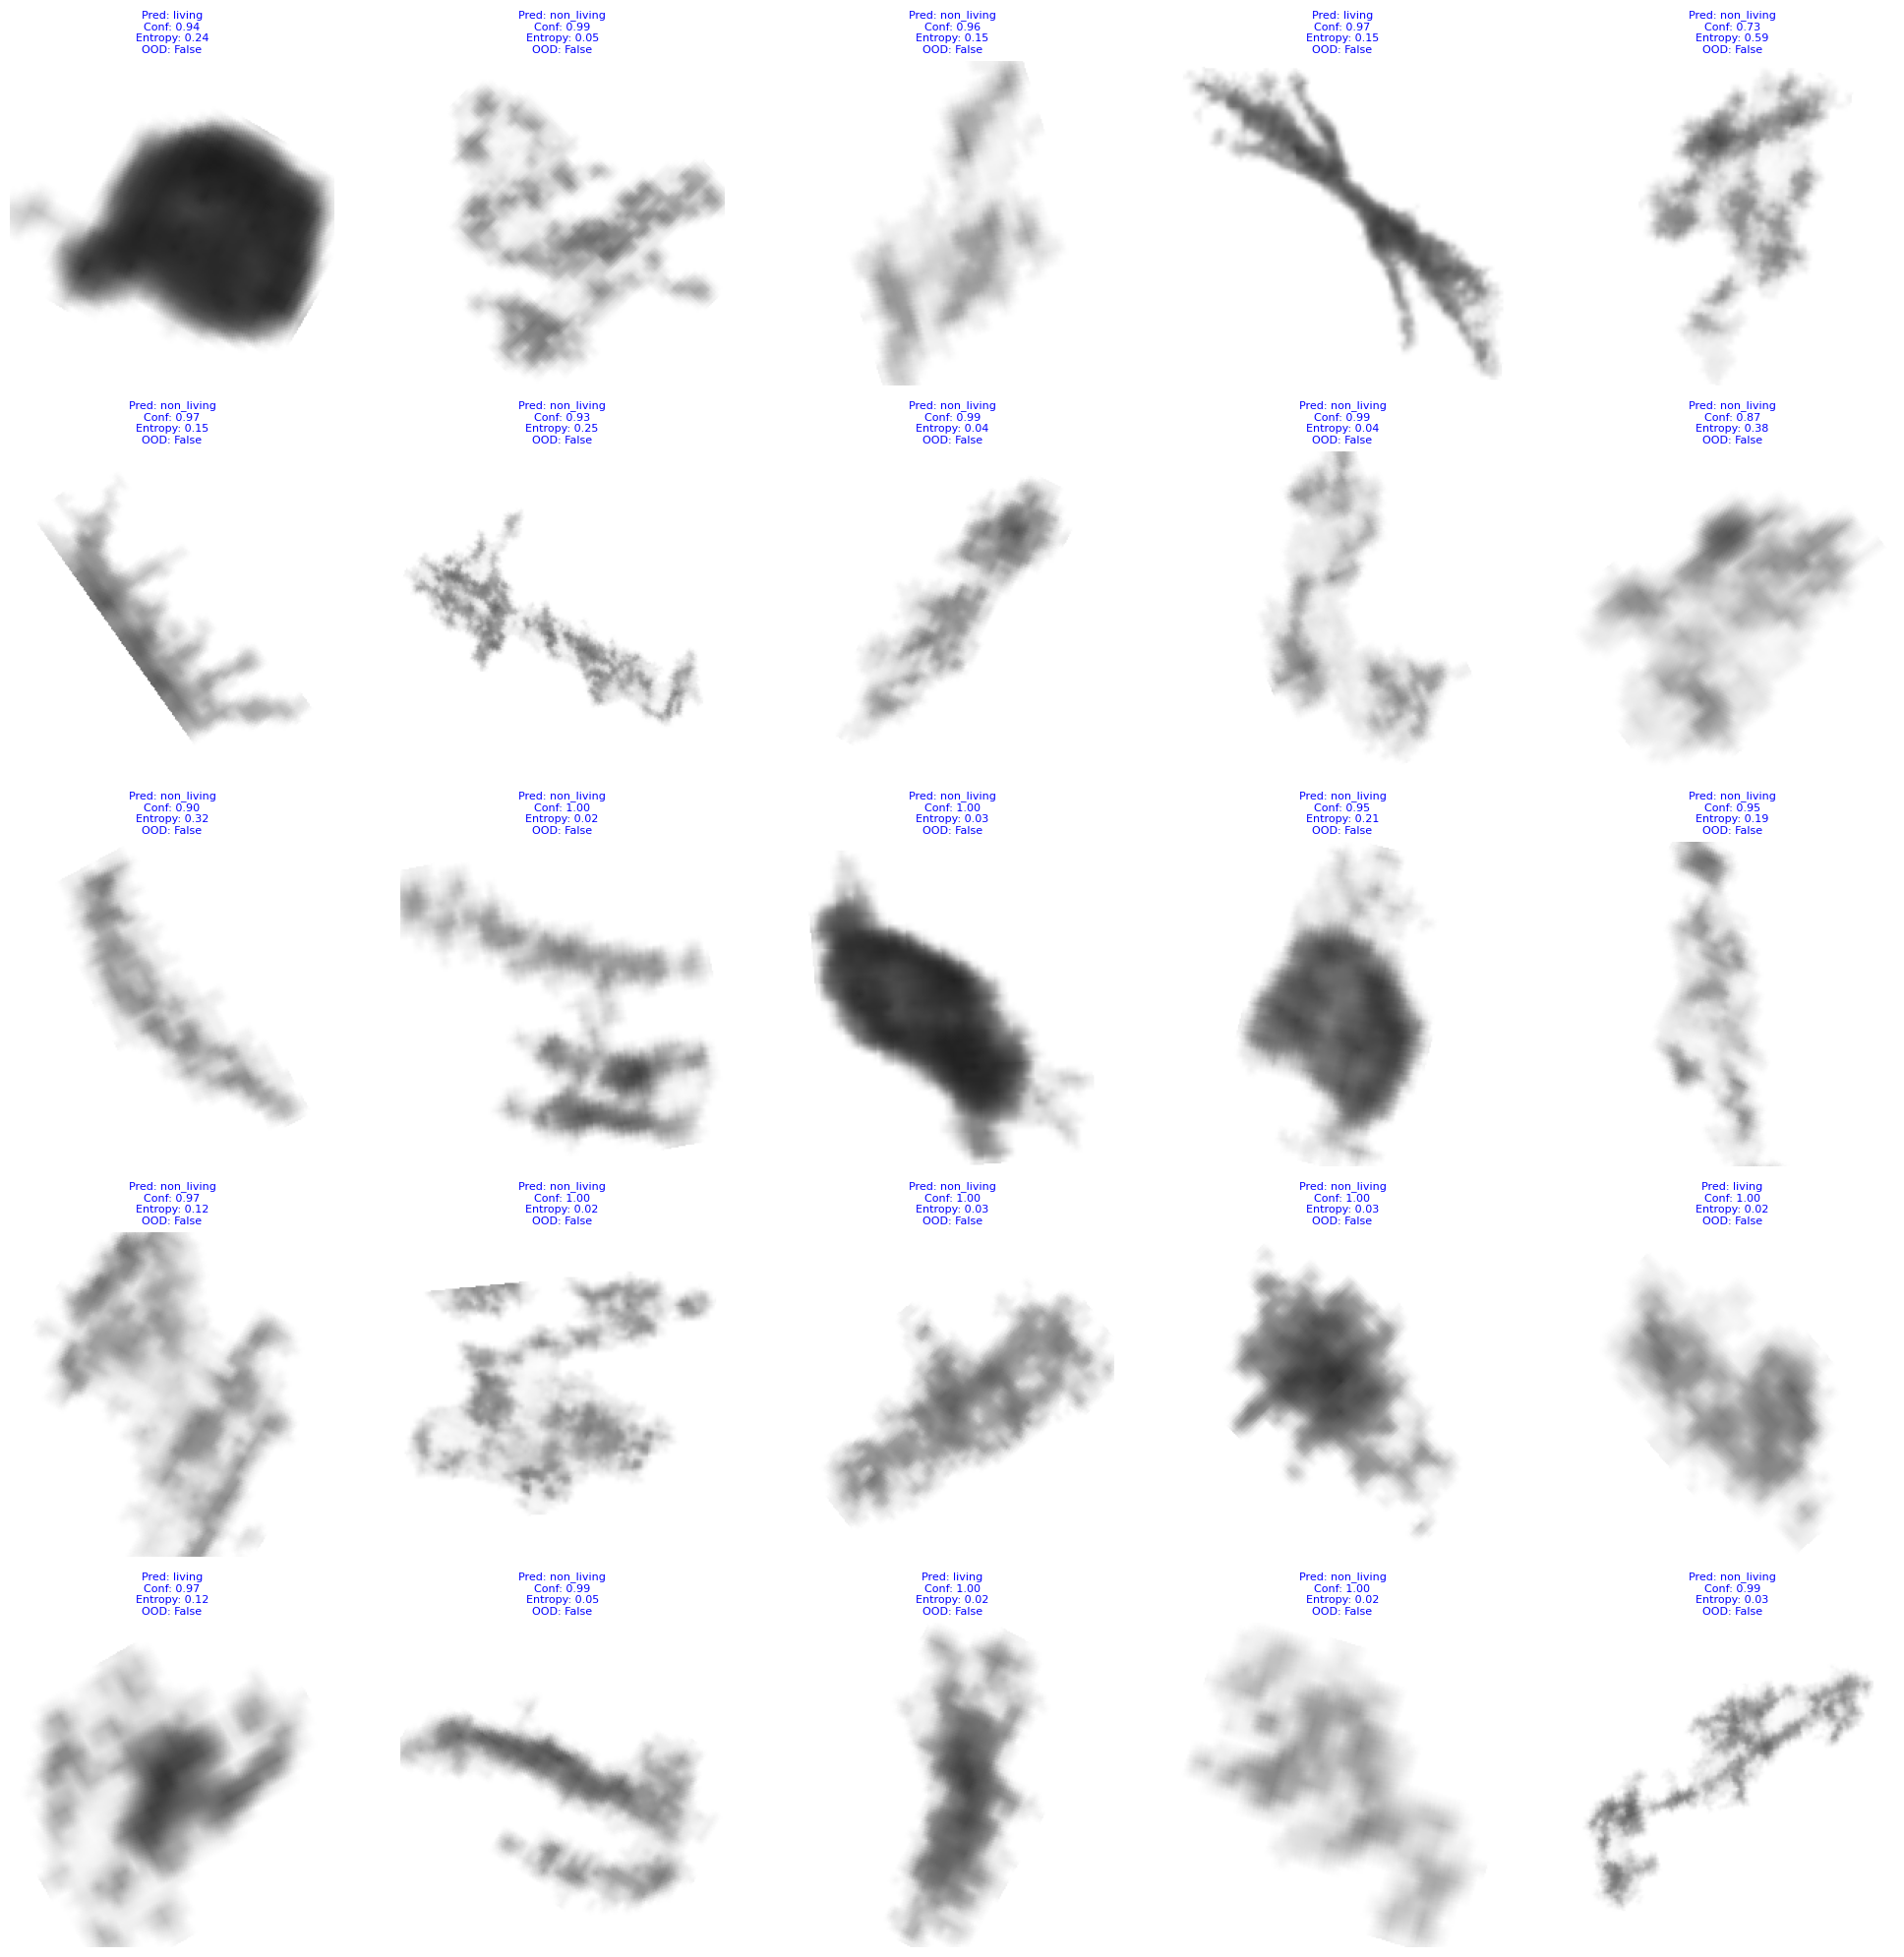


OOD Detection Summary:
Total samples: 105157
OOD samples: 0 (0.0%)

Visualizing only OOD samples:
No OOD samples found!


In [10]:
def visualize_inference(dataset, predictions, probabilities, entropy_scores=None, ood_flags=None, num_samples=25, rows=5, cols=5, only_ood=False):
    """
    Visualize random samples with their predicted labels and confidence scores.
    
    Args:
        dataset: Dataset with transformed images
        predictions: List of predictions for each image
        probabilities: List of confidence scores
        entropy_scores: List of entropy scores for OOD detection
        ood_flags: List of boolean flags indicating OOD samples
        num_samples: Number of samples to visualize
        rows: Number of rows in the grid
        cols: Number of columns in the grid
        only_ood: If True, show only OOD samples
    """
    # Get indices of samples to display
    total_samples = len(dataset)
    if only_ood and ood_flags is not None:
        # Verify lengths match
        if ood_flags is not None and len(ood_flags) != total_samples:
            print(f"Warning: Length mismatch - dataset: {total_samples}, ood_flags: {len(ood_flags)}")
            total_samples = min(total_samples, len(ood_flags))  # Use shorter length
            # Get indices of OOD samples
        ood_indices = [i for i in range(total_samples) if ood_flags[i]]
        if not ood_indices:
            print("No OOD samples found!")
            return
        random_indices = random.sample(ood_indices, min(num_samples, len(ood_indices)))
    else:
        random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Adjust grid size based on number of samples
    actual_samples = len(random_indices)
    if actual_samples < num_samples:
        rows = int(np.ceil(np.sqrt(actual_samples)))
        cols = rows
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    for idx, sample_idx in enumerate(random_indices):
        # Get image and prediction
        sample = dataset[sample_idx]
        pred_label = predictions[sample_idx][0]  # Top prediction
        confidence = probabilities[sample_idx][0]  # Top confidence
        
        # Get OOD information
        ood_flag = ood_flags[sample_idx] if ood_flags is not None else False
        entropy = entropy_scores[sample_idx] if entropy_scores is not None else None
        
        # Create color for title based on OOD flag
        title_color = 'orange' if ood_flag else 'blue'
        
        # Plot the image
        plt.subplot(rows, cols, idx + 1)
        # Convert tensor to image for display
        img = sample['pixel_values'].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(img)
        
        # Add title with predicted label, confidence and OOD info
        title = f'Pred: {pred_label}\nConf: {confidence:.2f}'
        if entropy is not None:
            title += f'\nEntropy: {entropy:.2f}'
        title += f'\nOOD: {ood_flag}'
        
        plt.title(title, color=title_color, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    if ood_flags is not None:
        total_ood = sum(ood_flags)
        print(f"\nOOD Detection Summary:")
        print(f"Total samples: {total_samples}")
        print(f"OOD samples: {total_ood} ({(total_ood/total_samples)*100:.1f}%)")

# Example usage:
print("\nVisualizing all samples:")
visualize_inference(ds_pisco_trans, predictions, probabilities, 
                   entropy_scores=entropy_scores, ood_flags=ood_flags)

print("\nVisualizing only OOD samples:")
visualize_inference(ds_pisco_trans, predictions, probabilities, 
                   entropy_scores=entropy_scores, ood_flags=ood_flags,
                   only_ood=True)

In [46]:
# Calculate the distribution of living vs non-living predictions
pred_distribution = df['top1'].value_counts()
total_samples = len(df)

print("\nPrediction Distribution:")
print("-" * 50)
for label, count in pred_distribution.items():
    percentage = (count/total_samples) * 100
    print(f"{label}: {count} samples ({percentage:.1f}%)")

# Calculate average confidence for each class
avg_confidence = df.groupby('top1')['prob1'].mean()
print("\nAverage Confidence by Class:")
print("-" * 50)
for label, conf in avg_confidence.items():
    print(f"{label}: {conf:.3f}")

# OOD Statistics by Class
ood_by_class = df.groupby('top1')['is_ood'].mean() * 100
print("\nOOD Percentage by Class:")
print("-" * 50)
for label, ood_pct in ood_by_class.items():
    print(f"{label}: {ood_pct:.1f}% flagged as OOD")


Prediction Distribution:
--------------------------------------------------
non_living: 89246 samples (84.9%)
living: 15890 samples (15.1%)

Average Confidence by Class:
--------------------------------------------------
living: 0.921
non_living: 0.963

OOD Percentage by Class:
--------------------------------------------------
living: 0.0% flagged as OOD
non_living: 0.0% flagged as OOD


In [ ]:
# First, filter images predicted as living
living_filenames = df[df['top1'] == 'living']['filename'].tolist()

# Create a new dataset with only the living predictions
living_data = {
    'image': living_filenames,
    'label': living_filenames
}

features = Features({
    'image': ImageFeature(),
    'label': Value('string')
})

ds_living = Dataset.from_dict(living_data, features=features)

# Apply the transform to the filtered dataset
ds_living_trans = ds_living.with_transform(process_batch)
model_dir = '/home/veit/PIScO_dev/ViT_custom_size_sensitive_v4/best_model'  

# Set up path for new predictions
destination_path_living = '/home/veit/PIScO_dev/ViT_custom_size_sensitive/predictions_living'
os.makedirs(destination_path_living, exist_ok=True)

# Run predictions on living subset with adjusted entropy threshold
filenames_living, predictions_living, probabilities_living, entropy_scores_living, ood_flags_living = get_predictions_with_entropy_ood(
    ds_living_trans, 
    model_dir, 
    entropy_threshold=0.9,  
    temperature=1.5,
    batch_size=64
)

# Create DataFrame for living predictions
df_living = pd.DataFrame({
    'filename': filenames_living,
    'is_ood': ood_flags_living,
    'entropy': entropy_scores_living,
    'top1': [pred[0] for pred in predictions_living],
    'top2': [pred[1] for pred in predictions_living],
    'top3': [pred[2] for pred in predictions_living],
    'top4': [pred[3] for pred in predictions_living],
    'top5': [pred[4] for pred in predictions_living],
    'prob1': [prob[0] for prob in probabilities_living],
    'prob2': [prob[1] for prob in probabilities_living],
    'prob3': [prob[2] for prob in probabilities_living],
    'prob4': [prob[3] for prob in probabilities_living],
    'prob5': [prob[4] for prob in probabilities_living]
})
# Save results
result_path_living = os.path.join(destination_path_living, 'ViT_predictions_living.csv')
df_living.to_csv(result_path_living, index=False)

# Print statistics
total_living = len(df_living)
ood_living = df_living['is_ood'].sum()

print("\nLiving Predictions Analysis:")
print("-" * 50)
print(f"Total living samples: {total_living}")
print(f"OOD samples among living: {ood_living} ({(ood_living/total_living)*100:.1f}%)")



Initializing model for predictions


Processing dataset: 100%|██████████| 249/249 [00:15<00:00, 16.07it/s]


Living Predictions Analysis:
--------------------------------------------------
Total living samples: 15887
OOD samples among living: 4940 (31.1%)



Visualizing samples from living predictions:


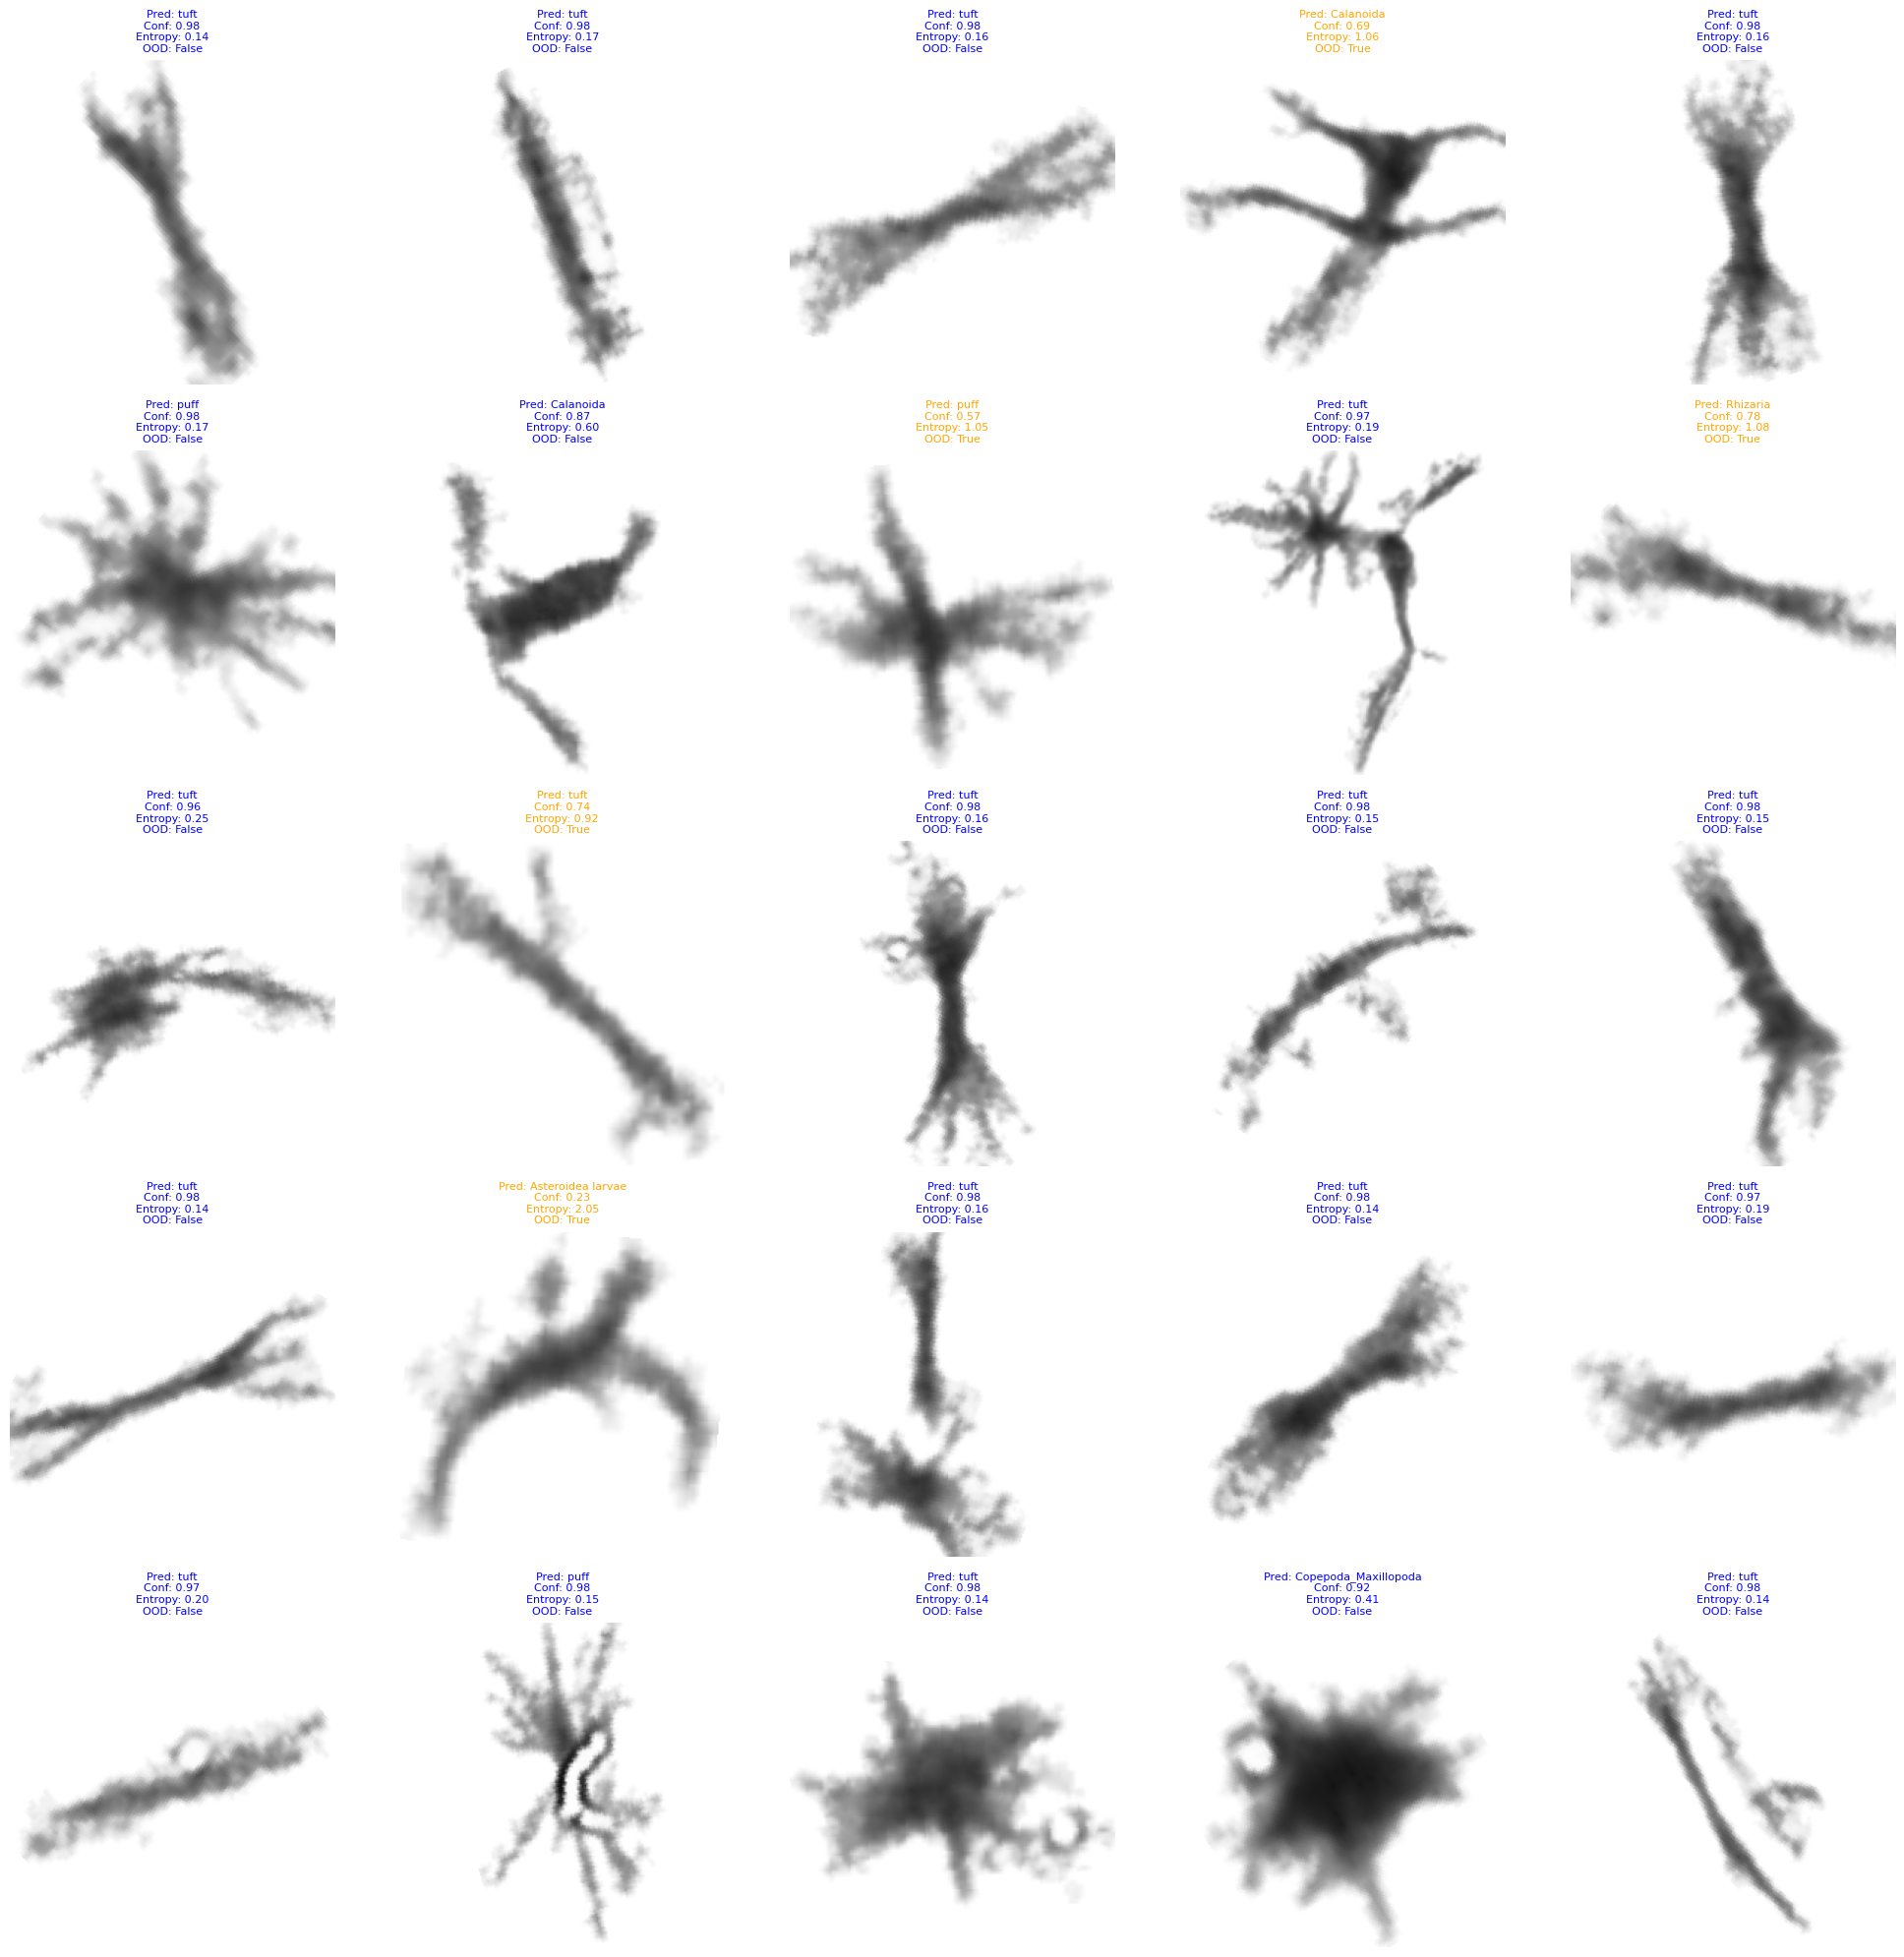


OOD Detection Summary:
Total samples: 15856
OOD samples: 2334 (14.7%)


In [22]:
# Visualize results
print("\nVisualizing samples from living predictions:")
visualize_inference(ds_living_trans, predictions_living, probabilities_living, 
                   entropy_scores=entropy_scores_living, 
                   ood_flags=ood_flags_living)

In [50]:
# Create a new combined DataFrame starting with the binary classification results
df_combined = df.copy()

# For rows predicted as 'living', add the detailed classification results
living_mask = df_combined['top1'] == 'living'

# Initialize new columns with empty values
df_combined['top2'] = ''
df_combined['top3'] = ''
df_combined['top4'] = ''
df_combined['top5'] = ''
df_combined['prob2'] = 0.0
df_combined['prob3'] = 0.0
df_combined['prob4'] = 0.0
df_combined['prob5'] = 0.0

# Update values only for living predictions
df_combined.loc[living_mask, 'top1'] = df_living['top1']
df_combined.loc[living_mask, 'top2'] = df_living['top2']
df_combined.loc[living_mask, 'top3'] = df_living['top3']
df_combined.loc[living_mask, 'top4'] = df_living['top4']
df_combined.loc[living_mask, 'top5'] = df_living['top5']
df_combined.loc[living_mask, 'prob1'] = df_living['prob1']
df_combined.loc[living_mask, 'prob2'] = df_living['prob2']
df_combined.loc[living_mask, 'prob3'] = df_living['prob3']
df_combined.loc[living_mask, 'prob4'] = df_living['prob4']
df_combined.loc[living_mask, 'prob5'] = df_living['prob5']
df_combined.loc[living_mask, 'entropy'] = df_living['entropy']
df_combined.loc[living_mask, 'is_ood'] = df_living['is_ood']

# Save the combined results
combined_path = os.path.join(destination_path, 'ViT_predictions.csv')
df_combined.to_csv(combined_path, index=False)

# Print summary statistics
print("\nCombined Predictions Analysis:")
print("-" * 50)
print(f"Total samples: {len(df_combined)}")
print(f"Living predictions: {living_mask.sum()} ({living_mask.mean()*100:.1f}%)")

# Show distribution of detailed classes for living predictions
detailed_dist = df_combined[living_mask]['top1'].value_counts()
print("\nDetailed Class Distribution (for living predictions):")
print("-" * 50)
for class_name, count in detailed_dist.items():
    percentage = (count/living_mask.sum()) * 100
    print(f"{class_name}: {count} samples ({percentage:.1f}%)")

# Show first few rows of combined predictions
print("\nSample of combined predictions:")
print(df_combined.head())

/tmp/ipykernel_1621464/1098197750.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[True False False ... nan nan nan]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_combined.loc[living_mask, 'is_ood'] = df_living['is_ood']



Combined Predictions Analysis:
--------------------------------------------------
Total samples: 105136
Living predictions: 15890 (15.1%)

Detailed Class Distribution (for living predictions):
--------------------------------------------------
tuft: 1192 samples (7.5%)
Copepoda_Maxillopoda: 300 samples (1.9%)
puff: 298 samples (1.9%)
Appendicularia: 199 samples (1.3%)
Rhizaria: 198 samples (1.2%)
Oithona: 60 samples (0.4%)
Calanoida: 50 samples (0.3%)
Pyrocystis: 28 samples (0.2%)
Cnidaria: 21 samples (0.1%)
Bacillariophyceae: 18 samples (0.1%)
Thaliacea: 14 samples (0.1%)
Asteroidea larvae: 9 samples (0.1%)
Chaetognatha: 8 samples (0.1%)
Ctenophora_Metazoa: 6 samples (0.0%)
Noctiluca sp.: 3 samples (0.0%)
Eumalacostraca: 1 samples (0.0%)

Sample of combined predictions:
                                            filename is_ood   entropy  \
0  /home/veit/PIScO_dev/Segmentation_results/M181...  False  0.630609   
1  /home/veit/PIScO_dev/Segmentation_results/M181...   True  1.462568  